In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import glob
import calendar
import pickle
import os
from scipy.integrate import odeint
from matplotlib import ticker
from tqdm import tqdm_notebook as tqdm
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.stats import circmean,circstd
from scipy.optimize import curve_fit
from scipy.stats import zscore
from sympy import *
import matplotlib.image as mpimg
from matplotlib.ticker import FormatStrFormatter

def_color=plt.rcParams['axes.prop_cycle'].by_key()['color']
font = {'size'   : 15}

#dictionaries of lab tests
pituitary_hormone_dic={'ACTH_ADRENOCORTICOTROPIC_HORMONE':'ACTH',
                    'TSH_THYROID_STIMULATING_HORMONE':'TSH',
                    'LH_LUTEINIZING_HORMONE':'LH',
                    'FSH_FOLLICLE_STIMULATING_HORMONE':'FSH',
                    'GROWTH_HORMONE_GH':'GH',
                    'PROLACTIN':'Prolactin'}

effector_hormone_dic={ 'CORTISOL_BLOOD':'Cortisol',
                     'CORTISOL_U_FREE_24h':'Urinary cortisol',
                     'T3_FREE':'T3-free',
                     'T4_FREE':'T4-free',
                     'ESTRADIOL_E_2':'Estradiol',
                     'TESTOSTERONE_TOTAL':'Testosterone',
                     'INSULIN_LIKE_GROWTH_FACTOR_1':'IGF1'}

residual_hormone_dic={ '17_HYDROXY_PROGESTERONE':'17OHPG',
                       'ALDOSTERONE_BLOOD'      :'ALD',
                       'ANDROSTENEDIONE'        :'AND',
                       'ANGIOTENSIN_I_CONVERTING_ENZYME':'ACE',
                       'DHEA_SULPHATE'          :'DHEA',
                       'PARATHYROID_HORMONE_PTH':'PTH',
                       'PROGESTERONE'           :'P4',
                       'T3_TOTAL'               :'T3-total',
                       'THYROGLOBULIN'          :'TGB'}

pituitary_unit_dict = {'ACTH':'Percentile',
                       'TSH' :'Percentile',
                       'LH'  :'Percentile',
                       'FSH' :'Percentile',
                       'Prolactin':'Percentile',
                       'GH'  :'Percentile'}

effector_unit_dict  = {'Cortisol':'Percentile',
                       'Urinary cortisol':'Percentile',
                       'T3-free':'Percentile',
                       'T4-free':'Percentile',
                       'Estradiol':'Percentile',
                       'Testosterone': 'Percentile',
                       'IGF1' :'Percentile'}

chem_dic            = {'CALCIUM_BLOOD':'Calcium',
                    'CREATININE_BLOOD':'Creatinine',
                    'Cl':'Cl',
                    'GLUCOSE_BLOOD':'Glucose',
                    'HEMOGLOBIN_A1C_CALCULATED':'HGB-A1C',
                    'HGB':'HGB',
                    'MAGNESIUM_BLOOD':'Mg',
                    'POTASSIUM':'K',
                    'SODIUM':'Na',
                    'UREA_BLOOD':'Urea'}
 
month_names=[x[:3] for x in calendar.month_name[1:13]]

In [4]:
def get_abs_amp(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the amplitude
    '''
    v=boots_mat[:,1]
    return np.mean(v),np.std(v)

def get_phase(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,2]
    return circmean(v,high=np.pi, low=-np.pi),circstd(v,high=np.pi, low=-np.pi)

def get_abs_amp2(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the amplitude
    '''
    v=boots_mat[:,3]
    return np.mean(v),np.std(v)

def get_phase2(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,4]
    return circmean(v,high=np.pi, low=-np.pi),circstd(v,high=np.pi, low=-np.pi)

def get_acrophase(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,5]
    return circmean(v,high=12, low=0),circstd(v,high=12, low=0)

def get_relmaxmin(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,6]
    return np.mean(v),np.std(v)

def seasonal_age_process(hormone,sex,dtype='quantile'):
    file    = '../data/Clalit_seasonality_Nov19/age.' + hormone +'.healthy_no_meds.' + dtype + '.with_infection.0.05.20_30_40_50_60_70_80.csv'
    df = pd.read_csv(file)
    
    df = df.loc[df['type'] != 'both']
    if sex != 'both':
        df = df.loc[df['type'] == sex]
        
#     zf = df.loc[df['age_group'] !='[70,80]'].copy()
#     zf = zf.loc[zf['age_group'] !='[60,70)']
#     zf = zf.loc[zf['age_group'] !='[50,60)']
    
#     # use ages 20-50 if there are more than 10k mesurements, if there are less, use ages 20-80
#     if np.sum(zf['n'].values)>10000:
#         df = zf

    df.loc[df['month'] == 12,['month']] = 0
    month_pooled_mean = []
    month_pooled_std  = []
    month_pooled_n    = []

    for month in np.arange(0,12):
        mdf = df.loc[df.month==month]
        month_pooled_mean.append(np.sum(mdf['mean']*mdf['n'])/np.sum(mdf['n']))
        month_pooled_std.append(np.sqrt(np.sum(mdf['std']**2*(mdf['n']-1))/(np.sum(mdf['n']) - len(mdf))))
        month_pooled_n.append(np.sum(mdf['n']))

    both_res = pd.DataFrame({'month': np.arange(0,12),
                             'mean' : month_pooled_mean,
                             'std'  : month_pooled_std,
                             'n'    : month_pooled_n})
    return both_res

def data2xy(data):
    '''
    Take a seasonality data from a file and change the months to angle (0,2*pi)
    return the angle month and the mean for each month
    '''
    xdat=2*np.pi*(np.arange(12)/12+25/365)#month
    ydat=np.array(data['mean'])#hormone value
    edat= np.array(data['std']/np.sqrt(data['n']))
    return xdat,ydat,edat

        
def fit_cosinor(xdat,ydat):
    '''
    compute the cosinor fit of data M+A*cos(w*t+phi),as well as the max-min of the data
    return the result as a vector
    the input should be after rescaling using data2xy function
    The fit is for x0 = December (assume 15/12, mid December) 
    '''    
    M       = np.mean(ydat)
    ydat    = ydat-M
    st      = np.std(ydat)
    maxamp  = np.max(abs(ydat))
    
    rel_maxmin= (np.max(ydat)-np.min(ydat))/2
    acrophase = ydat.argmax()

    # 1st order cosinor - 2 parameters: A,phi (normalized ydat to  mean = 0 in order to remove baseline fitting)
    res_fit, pcov = curve_fit(lambda x,A,phi: A*np.cos(x+phi),
                              xdat,
                              ydat,
                              p0=[st,0],
                              bounds=[(maxamp/20,-np.pi),(maxamp,np.pi)])
    A11         = res_fit[0]
    phi11       = res_fit[1]
    first_order = np.array([M,A11,phi11,0,0,acrophase,rel_maxmin])
    
    # 2st order cosinor - 4 parameters: A,phi (normalized ydat to  mean = 0 in order to remove baseline fitting)
    res_fit, pcov = curve_fit(lambda x,A1,phi1,A2,phi2: A1*np.cos(x+phi1) + A2*np.cos(2*x+phi2),
                              xdat,
                              ydat,
                              p0=[st,0,st,0],
                              bounds=[(maxamp/20,-np.pi,maxamp/20,-np.pi),(maxamp,np.pi,maxamp,np.pi)])
    
    A21          = res_fit[0]
    phi21        = res_fit[1]
    A22          = res_fit[2]
    phi22        = res_fit[3]
    second_order = np.array([M,A21,phi21,A22,phi22,acrophase,rel_maxmin])
    return first_order,second_order

def bootstrap_months_cosinor(data,hormone,sex,nboots=500):
    '''
    Apply bootstrapping, sampling random months from the data
    fit cosinor to each sample to obtain mean and std for the cosinor values
    '''
    # get data
    xdat,ydat,edat = data2xy(data)
    
    params=np.zeros([nboots,7])
    params2=np.zeros([nboots,7])

    #bootstrap data and fit first and second order cosinor to each iteration
    #bootsrap by randomly samlping each month from its errorbar (normal disturbiotion)
    for i in range(nboots):
        yboot = [np.random.normal(loc = y,scale = e) for y,e in zip(ydat,edat)]
        params[i,:],params2[i,:] = fit_cosinor(xdat,yboot)
        
    # avarage bootstrap to get cosinor parameters 
    cosinor_tables = []   
    for pars in [params,params2]:
        
        if hormone =='TESTOSTERONE_TOTAL':
            if sex =='male':
                winter_peak = pars[:,5] < 6
                pars        = pars[winter_peak]
                
        if hormone =='ESTRADIOL_E_2':
            if sex =='female':
                winter_peak = pars[:,5] < 6
                pars        = pars[winter_peak] 
                
        all_tests_phase     = []
        all_tests_phase2    = []
        all_tests_amp       = []
        all_tests_amp2      = []
        all_tests_acrophase = []
        all_tests_relmaxmin = []
        all_tests_phase      .append(get_phase(pars))
        all_tests_phase2     .append(get_phase2(pars))
        all_tests_amp        .append(get_abs_amp(pars))
        all_tests_amp2       .append(get_abs_amp2(pars))
        all_tests_acrophase  .append(get_acrophase(pars))
        all_tests_relmaxmin  .append(get_relmaxmin(pars))
        
        # normalize phase back to months
        phase_mean       = [np.mod(12/(2*np.pi)*(-x[0]),12) for x in all_tests_phase]
        phase_std        = [12/(2*np.pi)*x[1] for x in all_tests_phase]
        all_tests_phase  = [(phase_mean[i],phase_std[i]) for i in range(len(phase_mean))] 
        phase_mean2      = [np.mod(12/(2*np.pi)*(-x[0]),12) for x in all_tests_phase2]
        phase_std2       = [12/(2*np.pi)*x[1] for x in all_tests_phase2]
        all_tests_phase2 = [(phase_mean2[i],phase_std2[i]) for i in range(len(phase_mean2))] 
        
        all_tests_phase  = np.array(all_tests_phase).flat[:]
        all_tests_phase2 = np.array(all_tests_phase2).flat[:]
        all_tests_amp    = np.array(all_tests_amp).flat[:]
        all_tests_amp2   = np.array(all_tests_amp2).flat[:]
        all_tests_acrophase = np.array(all_tests_acrophase).flat[:]
        all_tests_relmaxmin = np.array(all_tests_relmaxmin).flat[:]
        cosinor_tables.append(np.array([all_tests_amp,all_tests_phase,all_tests_amp2,all_tests_phase2,all_tests_acrophase,all_tests_relmaxmin]))

    # calculate akaika infromation coeff and choose better fit as cosinor for lab test   
    aic1,aic2,aic_null = cosinors_aic(xdat,ydat,edat,cosinor_tables)
    
    best_model = np.argmin(np.array([aic1,aic2,aic_null])) 
    if best_model   == 0:
        print('1st order cosinor')
        return cosinor_tables[0]
    elif best_model == 1:
        print('2nd order cosinor')
        return cosinor_tables[1]
    else:
        print('constant')
        return np.zeros_like(cosinor_tables[0])
    
def cosinors_aic(xdat,ydat,edat,cosinor_tables):        
    M          = np.mean(ydat)
    n          = len(ydat)
    
    plt.errorbar(np.arange(0,12),ydat,edat,c='k')
    
    # first order
    amp        = cosinor_tables[0][0][0]
    phase      = cosinor_tables[0][1][0]
    p          = (phase/12)*2*np.pi - 2*np.pi/12
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
    residuals  = ydat - cosine
    ss_res     = np.sum(residuals**2)
    k          = 2
    aic1       = 2*k + n*log(ss_res/n) + 2*k*(k+1)/(n-k-1)
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
    plt.plot(np.linspace(0,12,num = 365),cosine,c='b')

    # seconde order
    amp        = cosinor_tables[1][0][0]
    phase      = cosinor_tables[1][1][0]
    p          = (phase/12)*2*np.pi - 2*np.pi/12
    amp2       = cosinor_tables[1][2][0]
    phase2     = cosinor_tables[1][3][0]
    p2         = (phase2/12)*2*np.pi - 2*np.pi/12
    
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12)) + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
    residuals  = ydat - cosine
    ss_res     = np.sum(residuals**2)
    k          = 4
    aic2       = 2*k + n*log(ss_res/n) + 2*k*(k+1)/(n-k-1)
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365)) + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
    plt.plot(np.linspace(0,12,num = 365),cosine,c='r')
    plt.xticks(ticks=np.arange(0,12))
    plt.grid()
    plt.show()
    
    ## null model
    residuals  = ydat - M # constant with mean = 0 
    ss_res     = np.sum(residuals**2)
    k          = 0
    aic_null   = 2*k + n*log(ss_res/n) + 2*k*(k+1)/(n-k-1)
    return aic1,aic2,aic_null   

def get_cosinor(hormone,sex,dtype='qunaitle'):
    dat           = seasonal_age_process(hormone,sex,dtype = dtype)
    cosinor_table = bootstrap_months_cosinor(dat,hormone,sex)
    return cosinor_table

def gen_hormone_list(hormone_dic,datatype='quantile'):
    hormone_list = {}
    for j,k in tqdm(enumerate(hormone_dic.keys())):
        sex_list = {}
        for i,sex in enumerate(['female','male','both']):
            print('--------------')
            print(k,sex)
            hormone = seasonal_age_process(k,sex,dtype = datatype)
            xloc = hormone['month'].values
            yloc = hormone['mean'].values
            err  = hormone['std']/hormone['n']**0.5
            ntot = np.sum(hormone['n'])

            hormone_table = get_cosinor(k,sex,dtype = datatype)
            amp           = hormone_table[0][0]
            amp_std       = hormone_table[0][1]
            phase         = hormone_table[1][0] - 1
            phase_std     = hormone_table[1][1]
            amp2          = hormone_table[2][0]
            amp_std2      = hormone_table[2][1]
            phase2        = hormone_table[3][0] - 1
            phase_std2    = hormone_table[3][1]
            acrophase     = hormone_table[4][0] 
            acrophase_std = hormone_table[4][1]
            maxmin        = hormone_table[5][0]
            maxmin_std    = hormone_table[5][1]
            
            p           = (phase/12)*2*np.pi
            p2          = (phase2/12)*2*np.pi
            cosine      = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
            cosine2     = cosine + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
            seasonal_data = {'Clalit'  :{'xloc':xloc,'yloc':yloc,'err':err,'ntot':ntot},
                             'Cosinor' :{'pars':[[phase,amp,acrophase,maxmin],[phase_std,amp_std,acrophase_std,maxmin_std]],'cosine':cosine},
                             'Cosinor2':{'pars':[[phase2,amp2,acrophase,maxmin],[phase_std2,amp_std2,acrophase_std,maxmin_std]],'cosine':cosine2}}
            print('acrophase = ' ,acrophase)
            print('maxmin/2 = ' ,maxmin)

            sex_list.update({sex:seasonal_data})
        hormone_list.update({hormone_dic[k]:sex_list})  
    return hormone_list

--------------
CORTISOL_BLOOD female
CORTISOL_BLOOD
CORTISOL_BLOOD


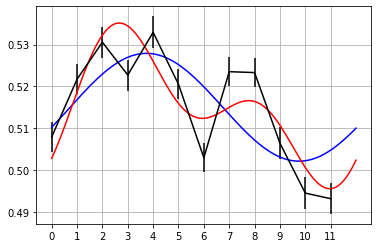

1st order cosinor
acrophase =  3.3797520160195487
maxmin/2 =  0.02099038519889558
--------------
CORTISOL_BLOOD male
CORTISOL_BLOOD
CORTISOL_BLOOD


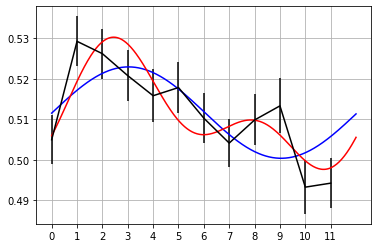

1st order cosinor
acrophase =  1.6268513862478835
maxmin/2 =  0.021046839815160392
--------------
CORTISOL_BLOOD both
CORTISOL_BLOOD
CORTISOL_BLOOD


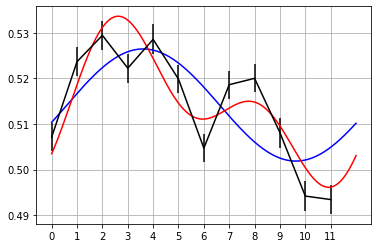

2nd order cosinor
acrophase =  2.7651891580520482
maxmin/2 =  0.01931965273226258
--------------
CORTISOL_U_FREE_24h female
CORTISOL_U_FREE_24h
CORTISOL_U_FREE_24h


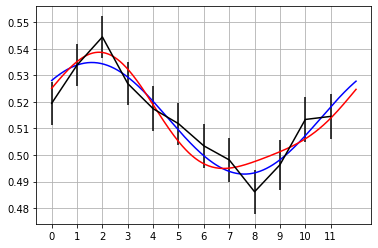

1st order cosinor
acrophase =  1.874617533495304
maxmin/2 =  0.030384521431603865
--------------
CORTISOL_U_FREE_24h male
CORTISOL_U_FREE_24h
CORTISOL_U_FREE_24h


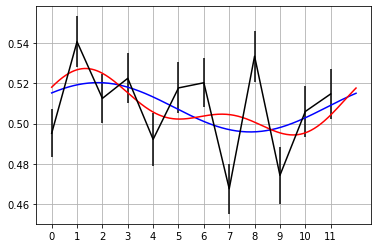

constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
CORTISOL_U_FREE_24h both
CORTISOL_U_FREE_24h
CORTISOL_U_FREE_24h


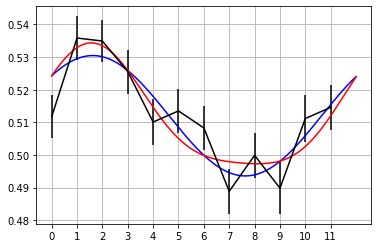

1st order cosinor
acrophase =  1.5449032522634218
maxmin/2 =  0.027586827354394407
--------------
T3_FREE female
T3_FREE
T3_FREE


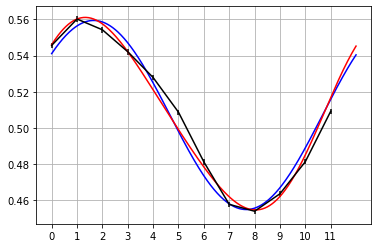

1st order cosinor
acrophase =  1.0019103705623915
maxmin/2 =  0.05322507621002482
--------------
T3_FREE male
T3_FREE
T3_FREE


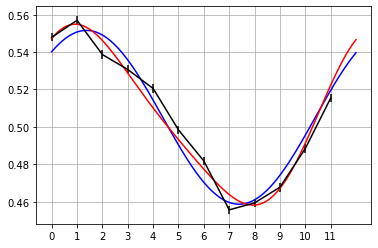

1st order cosinor
acrophase =  0.9942658298662301
maxmin/2 =  0.050824111230623886
--------------
T3_FREE both
T3_FREE
T3_FREE


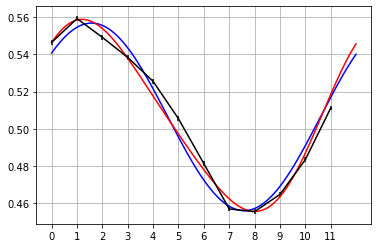

1st order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.051829487467706645
--------------
T4_FREE female
T4_FREE
T4_FREE


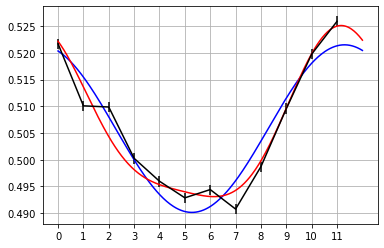

2nd order cosinor
acrophase =  11.00191037056239
maxmin/2 =  0.017523284197487988
--------------
T4_FREE male
T4_FREE
T4_FREE


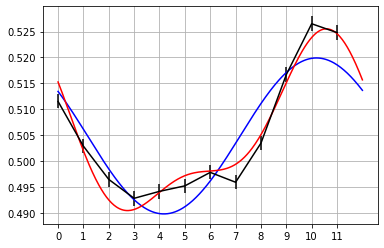

2nd order cosinor
acrophase =  10.21354327282792
maxmin/2 =  0.017108722826018153
--------------
T4_FREE both
T4_FREE
T4_FREE


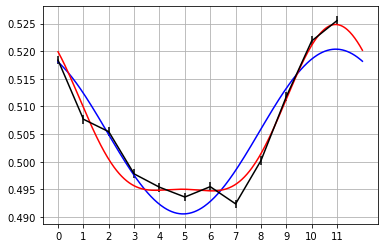

2nd order cosinor
acrophase =  10.999999999999998
maxmin/2 =  0.016630652698117112
--------------
ESTRADIOL_E_2 female
ESTRADIOL_E_2
ESTRADIOL_E_2


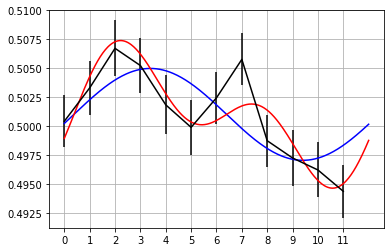

2nd order cosinor
acrophase =  2.264372459196895
maxmin/2 =  0.0073385874655799346
--------------
ESTRADIOL_E_2 male
ESTRADIOL_E_2
ESTRADIOL_E_2


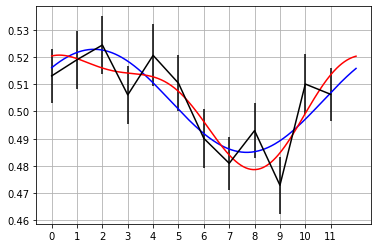

1st order cosinor
acrophase =  2.220002742579502
maxmin/2 =  0.030896599208142913
--------------
ESTRADIOL_E_2 both
ESTRADIOL_E_2
ESTRADIOL_E_2


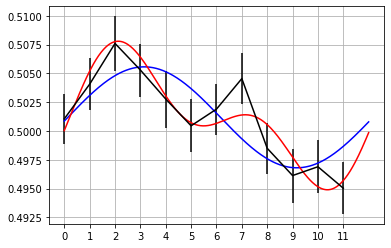

2nd order cosinor
acrophase =  2.3340176630264913
maxmin/2 =  0.007377312246400579
--------------
TESTOSTERONE_TOTAL female
TESTOSTERONE_TOTAL
TESTOSTERONE_TOTAL


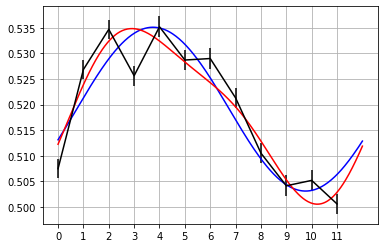

1st order cosinor
acrophase =  3.1565396945305997
maxmin/2 =  0.017936936044697083
--------------
TESTOSTERONE_TOTAL male
TESTOSTERONE_TOTAL
TESTOSTERONE_TOTAL


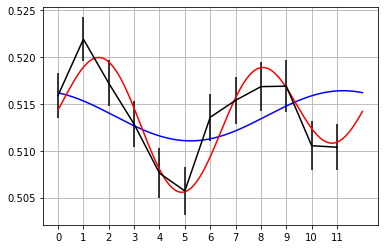

2nd order cosinor
acrophase =  1.0624292492664287
maxmin/2 =  0.008828618921996456
--------------
TESTOSTERONE_TOTAL both
TESTOSTERONE_TOTAL
TESTOSTERONE_TOTAL


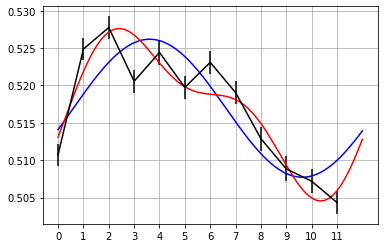

2nd order cosinor
acrophase =  2.033653125560487
maxmin/2 =  0.011835829390525198
--------------
INSULIN_LIKE_GROWTH_FACTOR_1 female
INSULIN_LIKE_GROWTH_FACTOR_1
INSULIN_LIKE_GROWTH_FACTOR_1


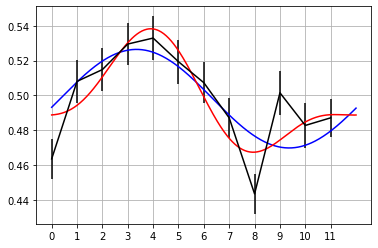

1st order cosinor
acrophase =  3.6739045309947724
maxmin/2 =  0.04855690815539272
--------------
INSULIN_LIKE_GROWTH_FACTOR_1 male
INSULIN_LIKE_GROWTH_FACTOR_1
INSULIN_LIKE_GROWTH_FACTOR_1


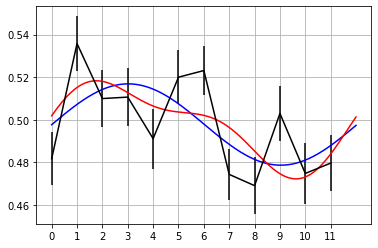

constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
INSULIN_LIKE_GROWTH_FACTOR_1 both
INSULIN_LIKE_GROWTH_FACTOR_1
INSULIN_LIKE_GROWTH_FACTOR_1


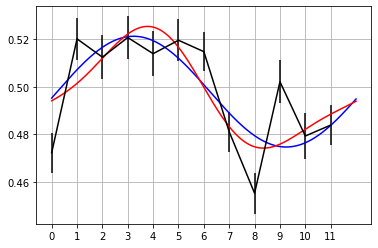

1st order cosinor
acrophase =  3.173299296182615
maxmin/2 =  0.037159690634657426


--------------
ACTH_ADRENOCORTICOTROPIC_HORMONE female
ACTH_ADRENOCORTICOTROPIC_HORMONE
ACTH_ADRENOCORTICOTROPIC_HORMONE


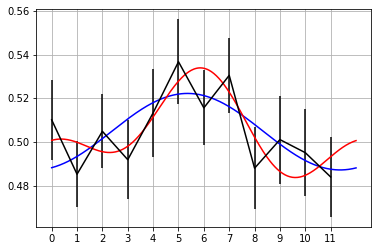

1st order cosinor
acrophase =  5.691291403052062
maxmin/2 =  0.04121919594594742
--------------
ACTH_ADRENOCORTICOTROPIC_HORMONE male
ACTH_ADRENOCORTICOTROPIC_HORMONE
ACTH_ADRENOCORTICOTROPIC_HORMONE


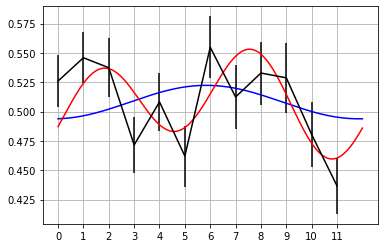

constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
ACTH_ADRENOCORTICOTROPIC_HORMONE both
ACTH_ADRENOCORTICOTROPIC_HORMONE
ACTH_ADRENOCORTICOTROPIC_HORMONE


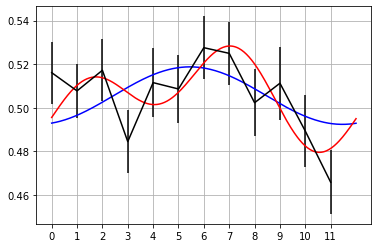

constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
TSH_THYROID_STIMULATING_HORMONE female
TSH_THYROID_STIMULATING_HORMONE
TSH_THYROID_STIMULATING_HORMONE


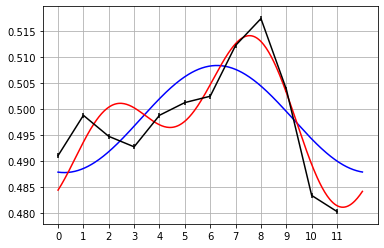

2nd order cosinor
acrophase =  7.999999999999997
maxmin/2 =  0.01849760409389399
--------------
TSH_THYROID_STIMULATING_HORMONE male
TSH_THYROID_STIMULATING_HORMONE
TSH_THYROID_STIMULATING_HORMONE


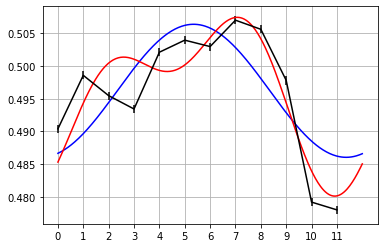

2nd order cosinor
acrophase =  7.03839781286323
maxmin/2 =  0.01453442872755766
--------------
TSH_THYROID_STIMULATING_HORMONE both
TSH_THYROID_STIMULATING_HORMONE
TSH_THYROID_STIMULATING_HORMONE


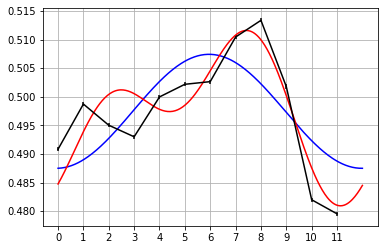

2nd order cosinor
acrophase =  7.999999999999997
maxmin/2 =  0.016909323296306632
--------------
LH_LUTEINIZING_HORMONE female
LH_LUTEINIZING_HORMONE
LH_LUTEINIZING_HORMONE


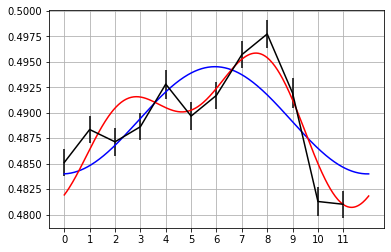

2nd order cosinor
acrophase =  7.8658849321994895
maxmin/2 =  0.00873280541769115
--------------
LH_LUTEINIZING_HORMONE male
LH_LUTEINIZING_HORMONE
LH_LUTEINIZING_HORMONE


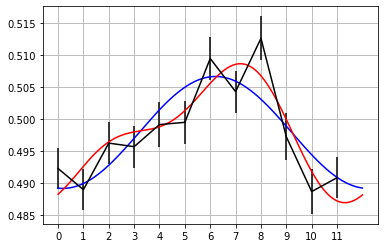

1st order cosinor
acrophase =  7.506840134334485
maxmin/2 =  0.01359178138297652
--------------
LH_LUTEINIZING_HORMONE both
LH_LUTEINIZING_HORMONE
LH_LUTEINIZING_HORMONE


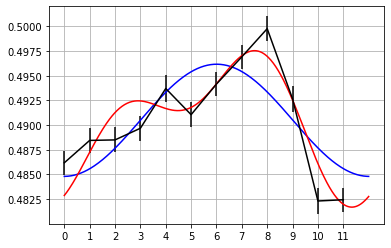

2nd order cosinor
acrophase =  7.9383773359653
maxmin/2 =  0.00903194076742336
--------------
FSH_FOLLICLE_STIMULATING_HORMONE female
FSH_FOLLICLE_STIMULATING_HORMONE
FSH_FOLLICLE_STIMULATING_HORMONE


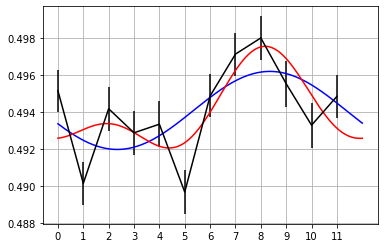

1st order cosinor
acrophase =  7.771760242493441
maxmin/2 =  0.004573675433435639
--------------
FSH_FOLLICLE_STIMULATING_HORMONE male
FSH_FOLLICLE_STIMULATING_HORMONE
FSH_FOLLICLE_STIMULATING_HORMONE


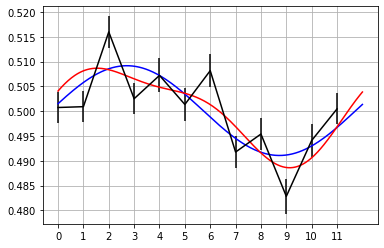

1st order cosinor
acrophase =  2.0918173461988143
maxmin/2 =  0.016817955248312665
--------------
FSH_FOLLICLE_STIMULATING_HORMONE both
FSH_FOLLICLE_STIMULATING_HORMONE
FSH_FOLLICLE_STIMULATING_HORMONE


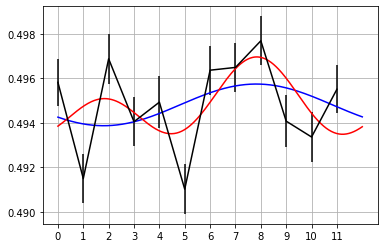

constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
GROWTH_HORMONE_GH female
GROWTH_HORMONE_GH
GROWTH_HORMONE_GH


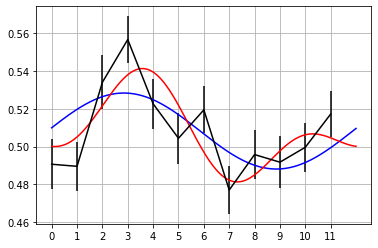

1st order cosinor
acrophase =  2.9157420733485093
maxmin/2 =  0.04328210455188265
--------------
GROWTH_HORMONE_GH male
GROWTH_HORMONE_GH
GROWTH_HORMONE_GH


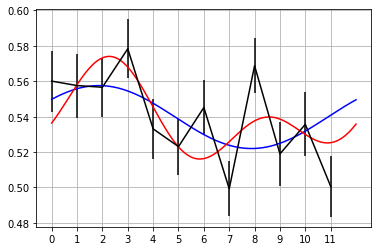

constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
GROWTH_HORMONE_GH both
GROWTH_HORMONE_GH
GROWTH_HORMONE_GH


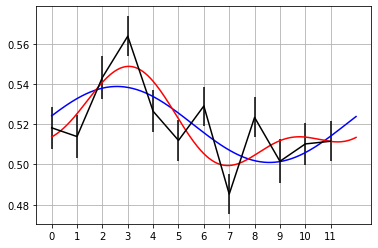

1st order cosinor
acrophase =  2.9461025311952342
maxmin/2 =  0.0405491998932267
--------------
PROLACTIN female
PROLACTIN
PROLACTIN


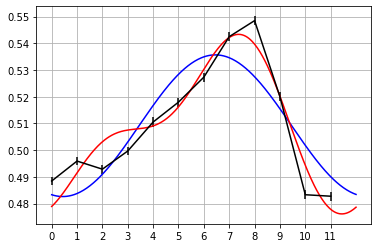

2nd order cosinor
acrophase =  7.996178238388326
maxmin/2 =  0.0332161617139232
--------------
PROLACTIN male
PROLACTIN
PROLACTIN


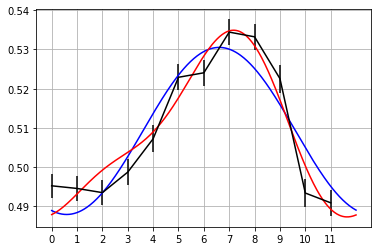

1st order cosinor
acrophase =  7.406037815772141
maxmin/2 =  0.023185770965700882
--------------
PROLACTIN both
PROLACTIN
PROLACTIN


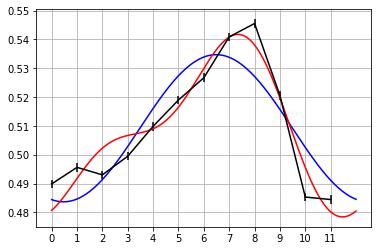

2nd order cosinor
acrophase =  7.986606081728747
maxmin/2 =  0.03076071319623702


--------------
17_HYDROXY_PROGESTERONE female
17_HYDROXY_PROGESTERONE
17_HYDROXY_PROGESTERONE


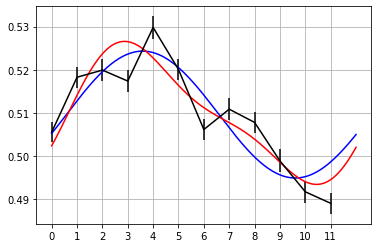

1st order cosinor
acrophase =  3.9947650729019375
maxmin/2 =  0.020641136857318443
--------------
17_HYDROXY_PROGESTERONE male
17_HYDROXY_PROGESTERONE
17_HYDROXY_PROGESTERONE


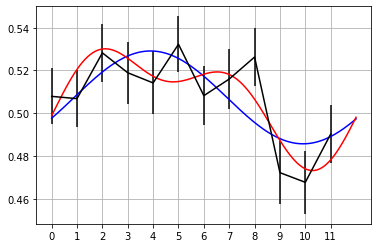

1st order cosinor
acrophase =  4.442014775605988
maxmin/2 =  0.04140572674149866
--------------
17_HYDROXY_PROGESTERONE both
17_HYDROXY_PROGESTERONE
17_HYDROXY_PROGESTERONE


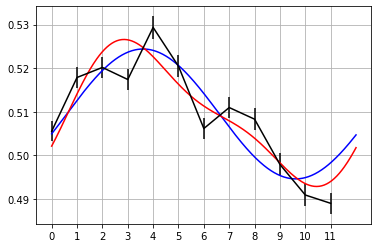

1st order cosinor
acrophase =  3.9943790516176696
maxmin/2 =  0.020406415886268077
--------------
ALDOSTERONE_BLOOD female
ALDOSTERONE_BLOOD
ALDOSTERONE_BLOOD


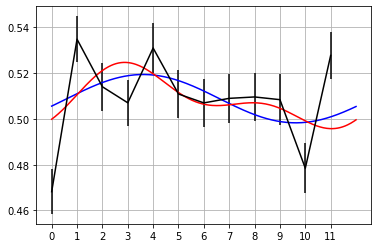

constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
ALDOSTERONE_BLOOD male
ALDOSTERONE_BLOOD
ALDOSTERONE_BLOOD


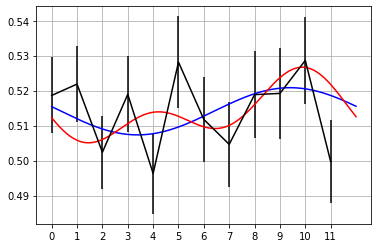

constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
ALDOSTERONE_BLOOD both
ALDOSTERONE_BLOOD
ALDOSTERONE_BLOOD


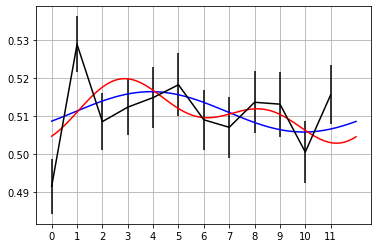

constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
ANDROSTENEDIONE female
ANDROSTENEDIONE
ANDROSTENEDIONE


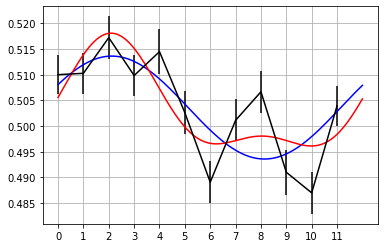

1st order cosinor
acrophase =  2.4522075564454
maxmin/2 =  0.016809346871080093
--------------
ANDROSTENEDIONE male
ANDROSTENEDIONE
ANDROSTENEDIONE


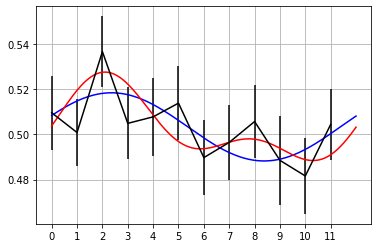

1st order cosinor
acrophase =  2.326780205557385
maxmin/2 =  0.03639787393115216
--------------
ANDROSTENEDIONE both
ANDROSTENEDIONE
ANDROSTENEDIONE


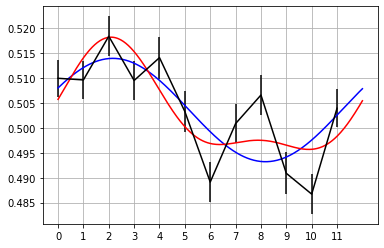

1st order cosinor
acrophase =  2.3836624112150973
maxmin/2 =  0.017088350618650234
--------------
ANGIOTENSIN_I_CONVERTING_ENZYME female
ANGIOTENSIN_I_CONVERTING_ENZYME
ANGIOTENSIN_I_CONVERTING_ENZYME


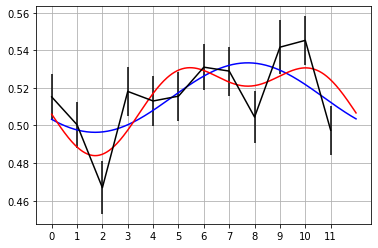

1st order cosinor
acrophase =  9.232113752001702
maxmin/2 =  0.04420825134405378
--------------
ANGIOTENSIN_I_CONVERTING_ENZYME male
ANGIOTENSIN_I_CONVERTING_ENZYME
ANGIOTENSIN_I_CONVERTING_ENZYME


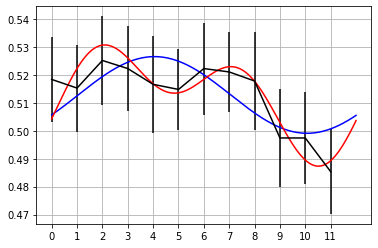

2nd order cosinor
acrophase =  4.581794841174613
maxmin/2 =  0.03334343664899991
--------------
ANGIOTENSIN_I_CONVERTING_ENZYME both
ANGIOTENSIN_I_CONVERTING_ENZYME
ANGIOTENSIN_I_CONVERTING_ENZYME


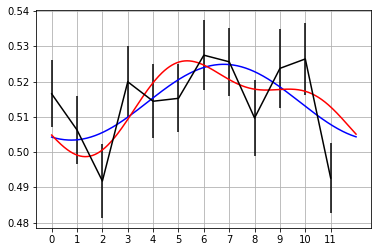

constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
DHEA_SULPHATE female
DHEA_SULPHATE
DHEA_SULPHATE


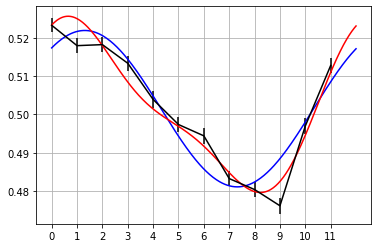

2nd order cosinor
acrophase =  0.07532490037228526
maxmin/2 =  0.0236728237449896
--------------
DHEA_SULPHATE male
DHEA_SULPHATE
DHEA_SULPHATE


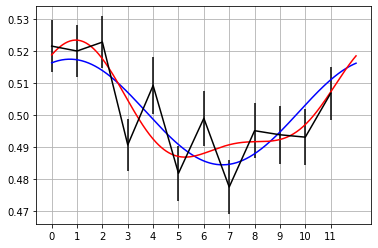

1st order cosinor
acrophase =  1.0183884859727408
maxmin/2 =  0.027291215506234572
--------------
DHEA_SULPHATE both
DHEA_SULPHATE
DHEA_SULPHATE


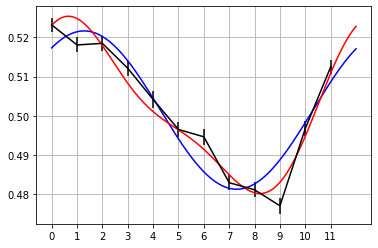

2nd order cosinor
acrophase =  0.11453749217159016
maxmin/2 =  0.02310513655312807
--------------
PARATHYROID_HORMONE_PTH female
PARATHYROID_HORMONE_PTH
PARATHYROID_HORMONE_PTH


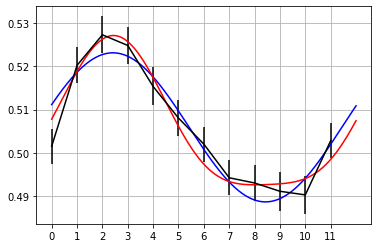

1st order cosinor
acrophase =  2.2202235009016644
maxmin/2 =  0.020755267277592224
--------------
PARATHYROID_HORMONE_PTH male
PARATHYROID_HORMONE_PTH
PARATHYROID_HORMONE_PTH


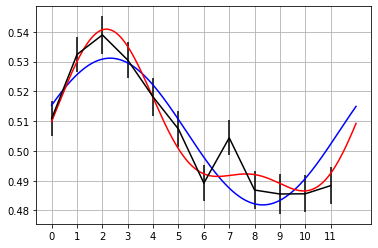

2nd order cosinor
acrophase =  1.9743435138702923
maxmin/2 =  0.030569163065397455
--------------
PARATHYROID_HORMONE_PTH both
PARATHYROID_HORMONE_PTH
PARATHYROID_HORMONE_PTH


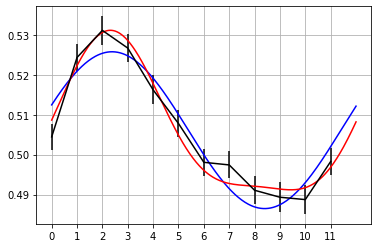

2nd order cosinor
acrophase =  2.1278257772431437
maxmin/2 =  0.022554746861014295
--------------
PROGESTERONE female
PROGESTERONE
PROGESTERONE


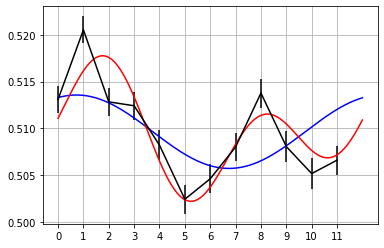

2nd order cosinor
acrophase =  0.9980829869341344
maxmin/2 =  0.009208785868295965
--------------
PROGESTERONE male
PROGESTERONE
PROGESTERONE


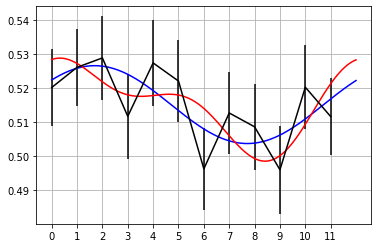

1st order cosinor
acrophase =  2.256874930290229
maxmin/2 =  0.0269671371891238
--------------
PROGESTERONE both
PROGESTERONE
PROGESTERONE


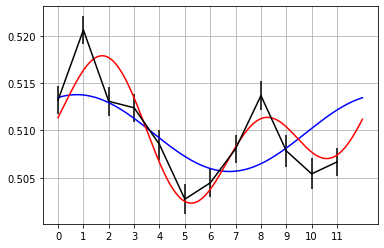

2nd order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.009210606933214793
--------------
T3_TOTAL female
T3_TOTAL
T3_TOTAL


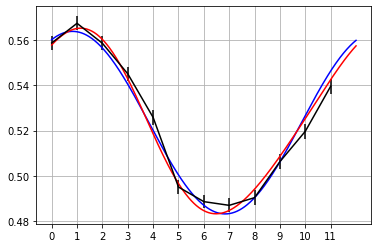

1st order cosinor
acrophase =  0.9826864801283443
maxmin/2 =  0.040887776532346376
--------------
T3_TOTAL male
T3_TOTAL
T3_TOTAL


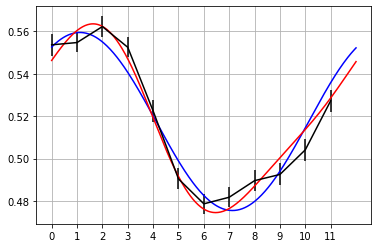

1st order cosinor
acrophase =  1.8177670424233565
maxmin/2 =  0.043162737825791976
--------------
T3_TOTAL both
T3_TOTAL
T3_TOTAL


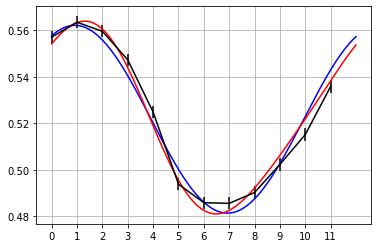

1st order cosinor
acrophase =  1.126777978251461
maxmin/2 =  0.039834458232125454
--------------
THYROGLOBULIN female
THYROGLOBULIN
THYROGLOBULIN


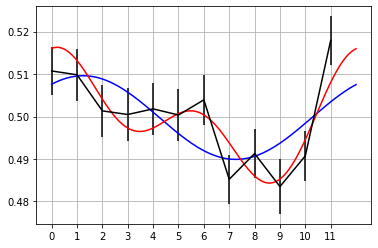

2nd order cosinor
acrophase =  11.41220911576329
maxmin/2 =  0.019497518645727244
--------------
THYROGLOBULIN male
THYROGLOBULIN
THYROGLOBULIN


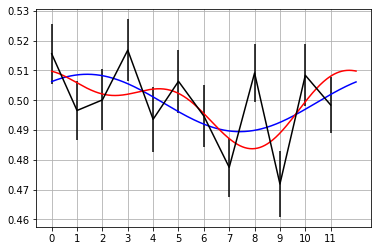

constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
THYROGLOBULIN both
THYROGLOBULIN
THYROGLOBULIN


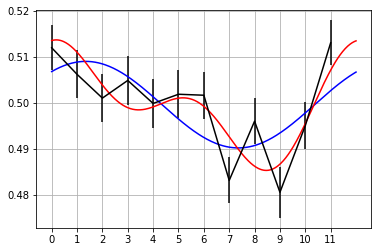

1st order cosinor
acrophase =  11.699973208169586
maxmin/2 =  0.018442098917921666


--------------
CALCIUM_BLOOD female
CALCIUM_BLOOD
CALCIUM_BLOOD


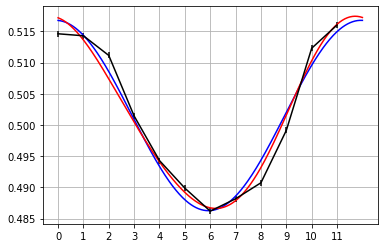

1st order cosinor
acrophase =  11.020061979991759
maxmin/2 =  0.0149035219449455
--------------
CALCIUM_BLOOD male
CALCIUM_BLOOD
CALCIUM_BLOOD


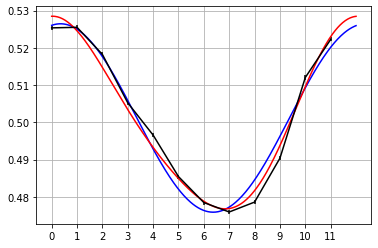

1st order cosinor
acrophase =  0.5879579449723186
maxmin/2 =  0.024897444971135684
--------------
CALCIUM_BLOOD both
CALCIUM_BLOOD
CALCIUM_BLOOD


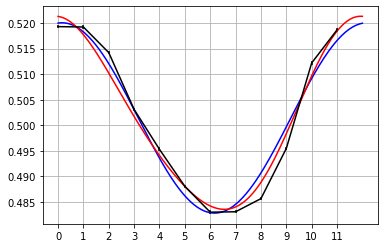

1st order cosinor
acrophase =  0.3729030733122447
maxmin/2 =  0.0183470270631478
--------------
CREATININE_BLOOD female
CREATININE_BLOOD
CREATININE_BLOOD


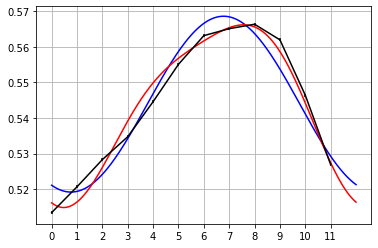

2nd order cosinor
acrophase =  7.992352406896756
maxmin/2 =  0.0264435381695517
--------------
CREATININE_BLOOD male
CREATININE_BLOOD
CREATININE_BLOOD


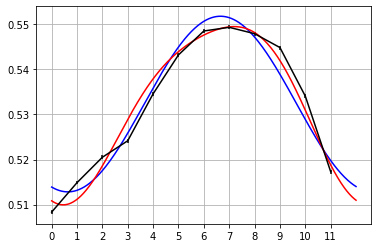

1st order cosinor
acrophase =  6.944105704466623
maxmin/2 =  0.020474916248011156
--------------
CREATININE_BLOOD both
CREATININE_BLOOD
CREATININE_BLOOD


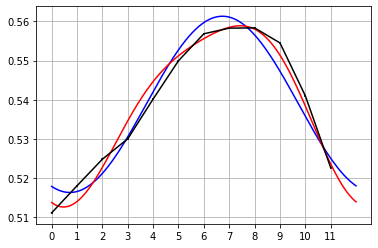

1st order cosinor
acrophase =  7.549116713865073
maxmin/2 =  0.023671866625413533
--------------
Cl female
Cl
Cl


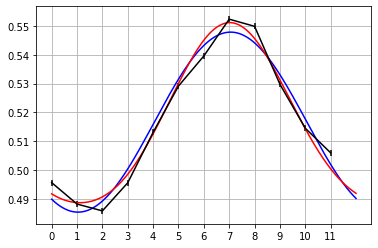

1st order cosinor
acrophase =  7.04032800760295
maxmin/2 =  0.033237722559913425
--------------
Cl male
Cl
Cl


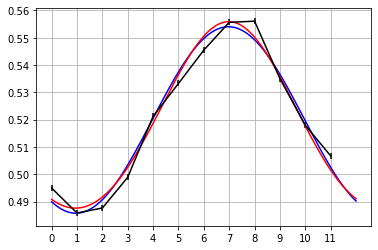

1st order cosinor
acrophase =  7.5695665727706505
maxmin/2 =  0.03541472146291688
--------------
Cl both
Cl
Cl


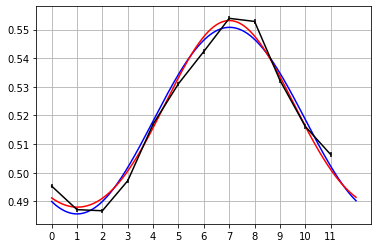

1st order cosinor
acrophase =  7.143915580277742
maxmin/2 =  0.033772044257099065
--------------
GLUCOSE_BLOOD female
GLUCOSE_BLOOD
GLUCOSE_BLOOD


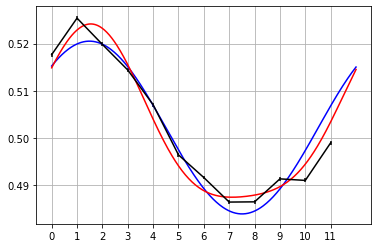

1st order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.019571239653945006
--------------
GLUCOSE_BLOOD male
GLUCOSE_BLOOD
GLUCOSE_BLOOD


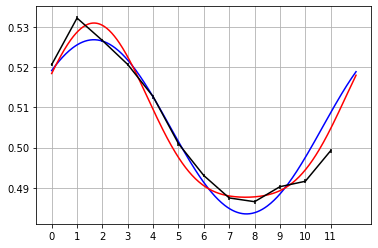

1st order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.0228132583881625
--------------
GLUCOSE_BLOOD both
GLUCOSE_BLOOD
GLUCOSE_BLOOD


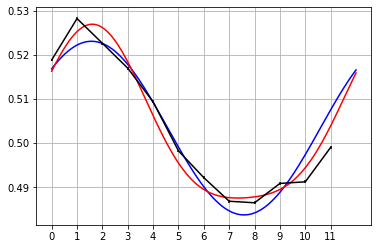

1st order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.02091690741155083
--------------
HEMOGLOBIN_A1C_CALCULATED female
HEMOGLOBIN_A1C_CALCULATED
HEMOGLOBIN_A1C_CALCULATED


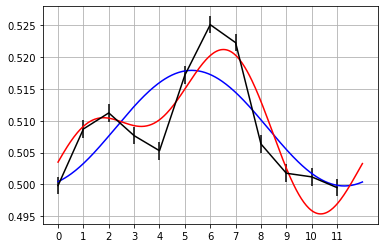

2nd order cosinor
acrophase =  6.0986644497178855
maxmin/2 =  0.013177104054715928
--------------
HEMOGLOBIN_A1C_CALCULATED male
HEMOGLOBIN_A1C_CALCULATED
HEMOGLOBIN_A1C_CALCULATED


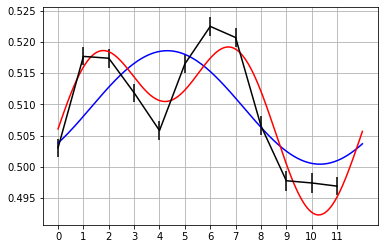

2nd order cosinor
acrophase =  6.177521084904481
maxmin/2 =  0.013383938784109222
--------------
HEMOGLOBIN_A1C_CALCULATED both
HEMOGLOBIN_A1C_CALCULATED
HEMOGLOBIN_A1C_CALCULATED


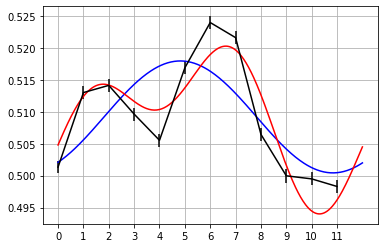

2nd order cosinor
acrophase =  6.04612432723692
maxmin/2 =  0.012953962139161664
--------------
HGB female
HGB
HGB


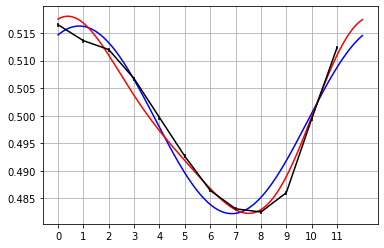

2nd order cosinor
acrophase =  0.0
maxmin/2 =  0.01701400744291996
--------------
HGB male
HGB
HGB


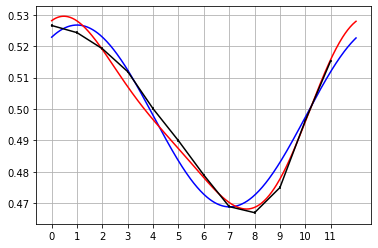

2nd order cosinor
acrophase =  0.0
maxmin/2 =  0.029806825311600317
--------------
HGB both
HGB
HGB


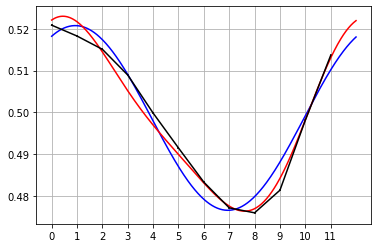

2nd order cosinor
acrophase =  0.0
maxmin/2 =  0.022465575804296103
--------------
MAGNESIUM_BLOOD female
MAGNESIUM_BLOOD
MAGNESIUM_BLOOD


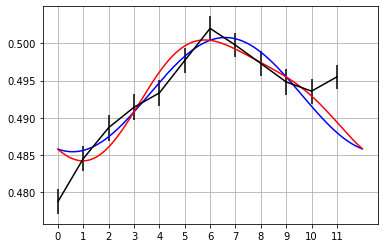

1st order cosinor
acrophase =  6.135919363841409
maxmin/2 =  0.01167549991881235
--------------
MAGNESIUM_BLOOD male
MAGNESIUM_BLOOD
MAGNESIUM_BLOOD


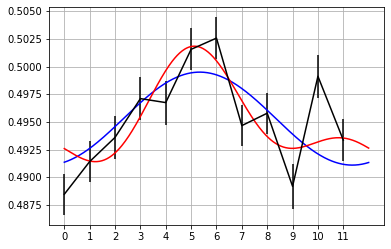

1st order cosinor
acrophase =  5.707948298055703
maxmin/2 =  0.007782309072927555
--------------
MAGNESIUM_BLOOD both
MAGNESIUM_BLOOD
MAGNESIUM_BLOOD


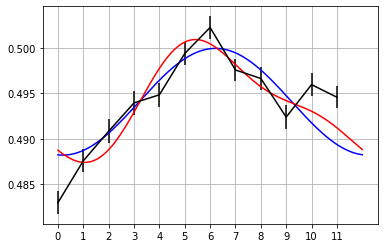

1st order cosinor
acrophase =  5.955737155106104
maxmin/2 =  0.009655296445189759
--------------
POTASSIUM female
POTASSIUM
POTASSIUM


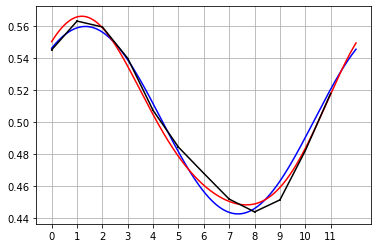

1st order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.059579024978276746
--------------
POTASSIUM male
POTASSIUM
POTASSIUM


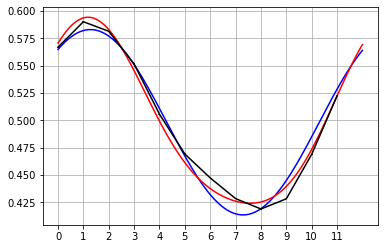

2nd order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.08564898697098386
--------------
POTASSIUM both
POTASSIUM
POTASSIUM


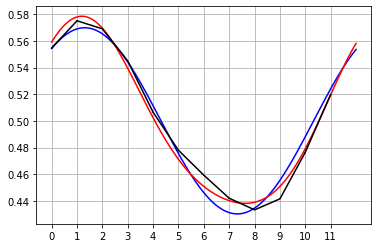

2nd order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.07083625071013172
--------------
SODIUM female
SODIUM
SODIUM


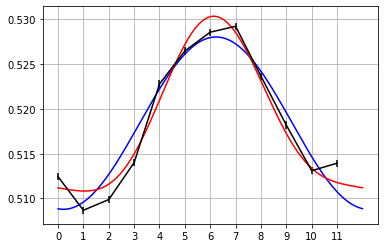

2nd order cosinor
acrophase =  6.848171706274709
maxmin/2 =  0.010273271472386228
--------------
SODIUM male
SODIUM
SODIUM


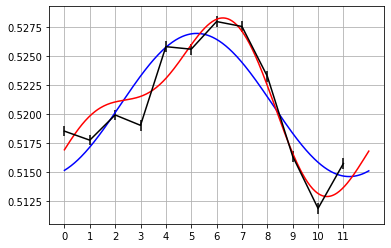

2nd order cosinor
acrophase =  6.2516771885755915
maxmin/2 =  0.008082290452919362
--------------
SODIUM both
SODIUM
SODIUM


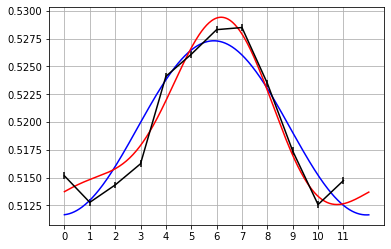

2nd order cosinor
acrophase =  6.665390783278007
maxmin/2 =  0.00805522928883391
--------------
UREA_BLOOD female
UREA_BLOOD
UREA_BLOOD


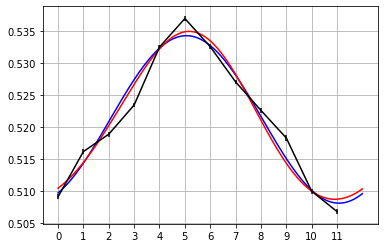

1st order cosinor
acrophase =  5.0
maxmin/2 =  0.015048026105298467
--------------
UREA_BLOOD male
UREA_BLOOD
UREA_BLOOD


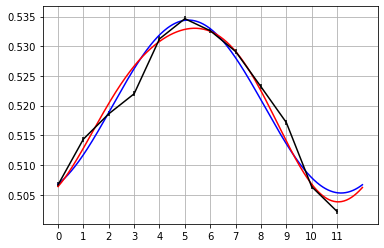

1st order cosinor
acrophase =  5.0
maxmin/2 =  0.01622373825357611
--------------
UREA_BLOOD both
UREA_BLOOD
UREA_BLOOD


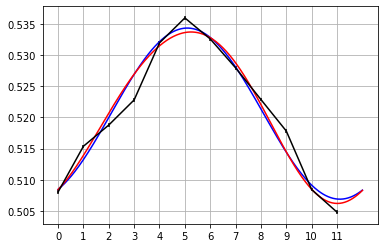

1st order cosinor
acrophase =  5.0
maxmin/2 =  0.015572682025706228


In [5]:
effector_list  = gen_hormone_list(effector_hormone_dic)
pituitary_list = gen_hormone_list(pituitary_hormone_dic)
# residual_list  = gen_hormone_list(residual_hormone_dic)
# chem_list      = gen_hormone_list(chem_dic)

pickle.dump([pituitary_list,effector_list,residual_list,chem_list],open('seasonality_processed_data0601_20_80.pickle','wb'))

In [6]:
[pituitary_list,effector_list,residual_list,chem_list] = pickle.load(open('seasonality_processed_data0601_20_80.pickle','rb'))

D:\Anaconda\envs\venv\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\Anaconda\envs\venv\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


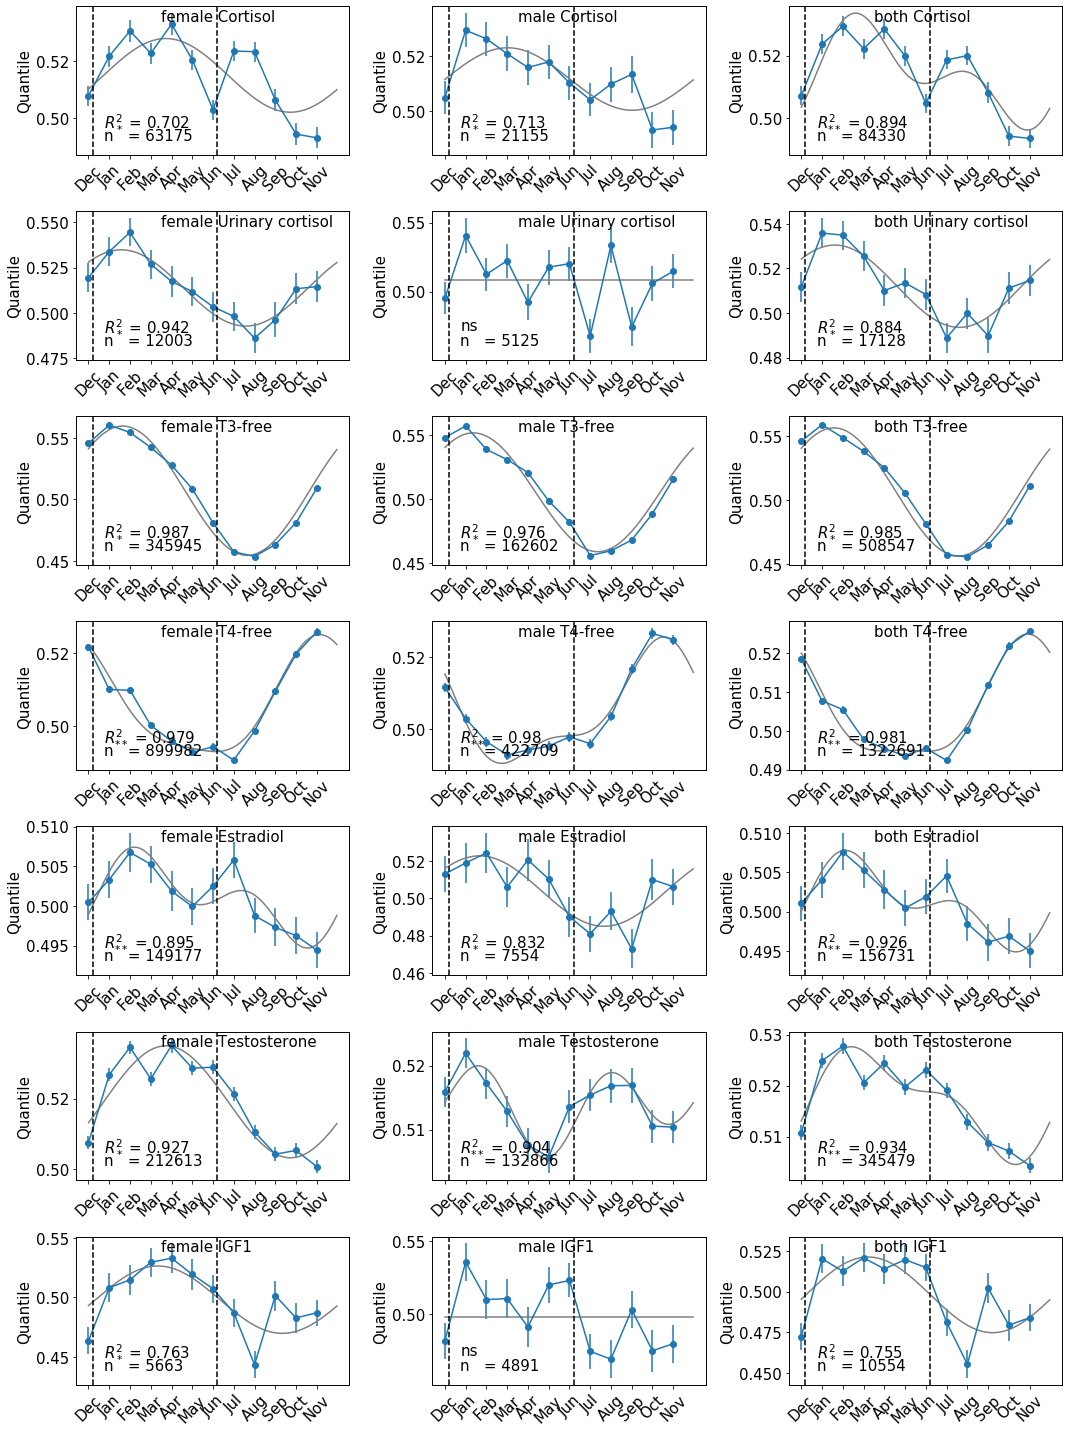

In [7]:
'''
plot effector hormones seasonality
'''
eff_r2df = pd.DataFrame(columns = ['sex','hormone','r2'])

plt.figure(figsize=(15,20))
for j,k in tqdm(enumerate(effector_hormone_dic.keys())):
    for i,sex in enumerate(['female','male','both']):
        
        xloc    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = effector_list[effector_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = effector_list[effector_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = effector_list[effector_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = effector_list[effector_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = effector_list[effector_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]

        if amp2 >0:
            rstr = '$R_{**}^2$'
        elif amp > 0:
            rstr = '$R_*^2$'
        else:
            rstr = 'ns'
        
        p        = ((phase)/12)*2*np.pi
        p2       = ((phase2)/12)*2*np.pi
        
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
                
        R2       = np.corrcoef(yloc,cosine2)[0,1]
        eff_r2df = eff_r2df.append(pd.DataFrame({'sex':sex,'hormone':k,'r2':[R2]}))
        
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        #plot
        ax = plt.subplot(7,3,1+i +j*3)
        ax.errorbar(xloc,yloc,err,c=def_color[0],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-1],cosine2,c='gray')
        ax.set_xticks(np.arange(12))
        ax.set_xticklabels(np.roll(month_names,1), rotation=45,fontsize=15)
        ax.set_ylabel(effector_unit_dict[effector_hormone_dic[k]],fontsize=15)
        ax.tick_params(axis="y", labelsize=15)
        axn = ax.twinx()
        axn.set_yticks([])
        axn.annotate('n   = '+str(ntot),(0.75,0.1),fontsize=15)
        if rstr == 'ns':
            axn.annotate(rstr,(0.75,0.2),fontsize=15)
        else:
            axn.annotate(rstr+' = '+str(np.round(R2,decimals=3)),(0.75,0.2),fontsize=15)
        axn.annotate(sex + ' ' + effector_hormone_dic[k],(3.5,0.9),fontsize=15,fontweight='roman')
        
        ## x0 = Dec 15, so add 6 days to get Dec 21st
        ## in month resulotion, 6 days are 0.2 month
        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')

plt.tight_layout()
# plt.savefig('../figures/Seasonality24112019/effector_subplots_1912_20_80.pdf',bbox_inches='tight',dpi=600)
plt.show()

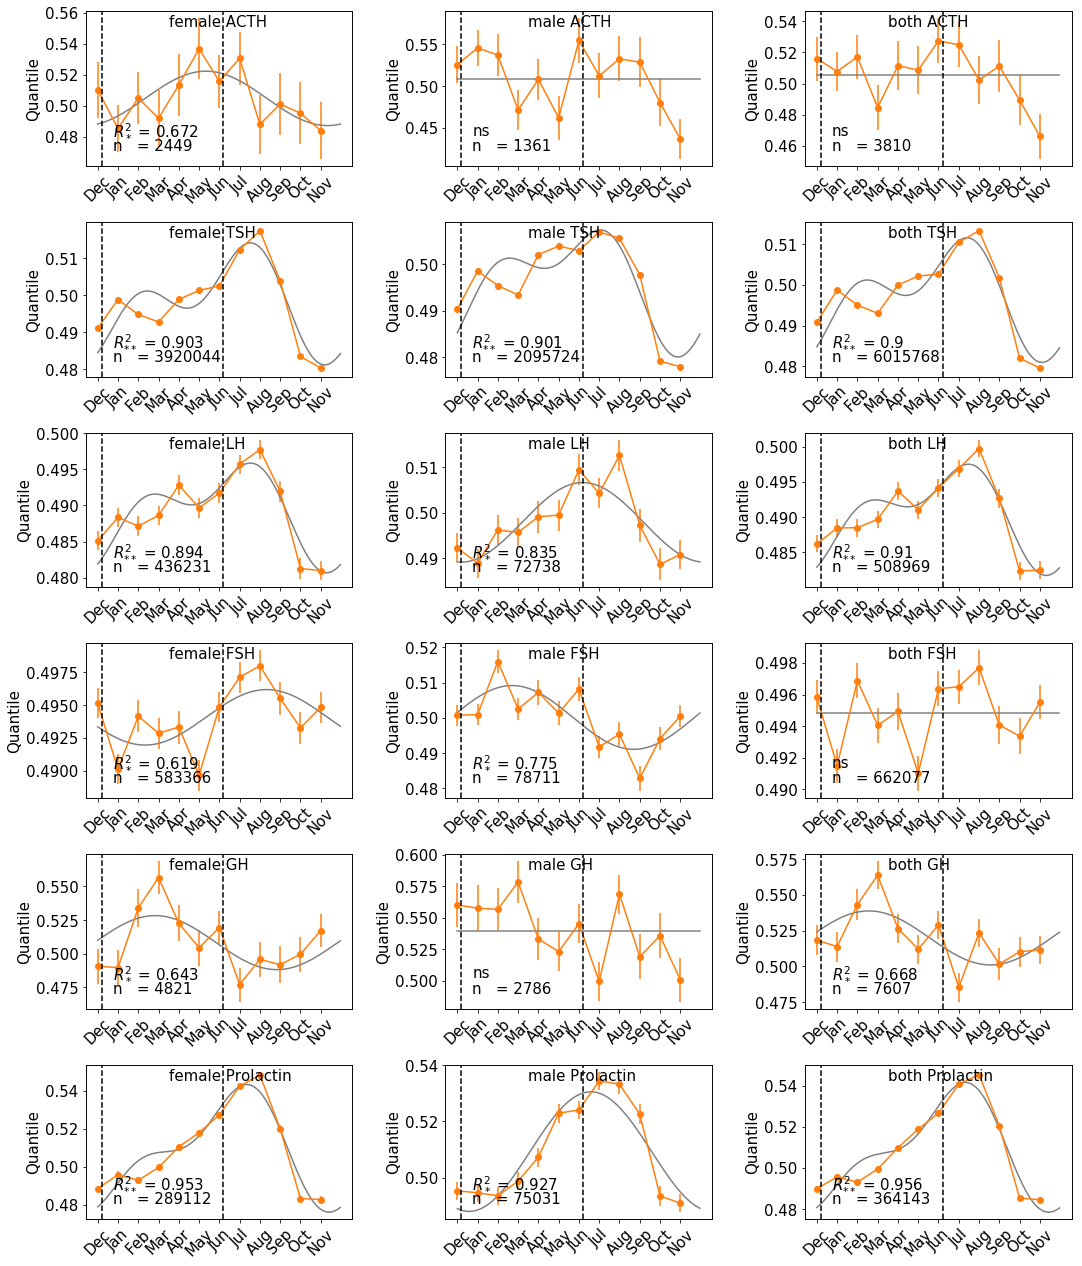

In [8]:
'''
plot pituitary hormones seasonality
'''
pit_r2df = pd.DataFrame(columns = ['sex','hormone','r2'])

plt.figure(figsize=(15,20))
for j,k in tqdm(enumerate(pituitary_hormone_dic.keys())):
    for i,sex in enumerate(['female','male','both']):        
        xloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]

        if amp2 >0:
            rstr = '$R_{**}^2$'
        elif amp > 0:
            rstr = '$R_*^2$'
        else:
            rstr = 'ns'
        
        # months are stored iin the dataframe in a january-december fmt, 
        # this part will make december as the 0th month

        p        = ((phase)/12)*2*np.pi
        p2       = ((phase2)/12)*2*np.pi
        
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        R2       = np.corrcoef(yloc,cosine2)[0,1]
        pit_r2df = pit_r2df.append(pd.DataFrame({'sex':sex,'hormone':k,'r2':[R2]}))

        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        #plot
        ax = plt.subplot(7,3,1+i +j*3)
        ax.errorbar(xloc,yloc,err,c=def_color[1],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-1],cosine2,c='gray')
        ax.set_xticks(np.arange(12))
        ax.set_xticklabels(np.roll(month_names,1), rotation=45,fontsize=15)
        ax.set_ylabel(pituitary_unit_dict[pituitary_hormone_dic[k]],fontsize=15)
        ax.tick_params(axis="y", labelsize=15)
        axn = ax.twinx()
        axn.set_yticks([])
        axn.annotate('n   = '+str(ntot),(0.75,0.1),fontsize=15)
        if rstr == 'ns':
            axn.annotate(rstr,(0.75,0.2),fontsize=15)
        else:
            axn.annotate(rstr+' = '+str(np.round(R2,decimals=3)),(0.75,0.2),fontsize=15)
        axn.annotate(sex + ' ' + pituitary_hormone_dic[k],(3.5,0.9),fontsize=15,fontweight='roman')
        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')
        
plt.tight_layout()
# plt.savefig('../figures/Seasonality24112019/pituitary_subplots_1912_20_80.pdf',bbox_inches='tight',dpi=600)
plt.show()

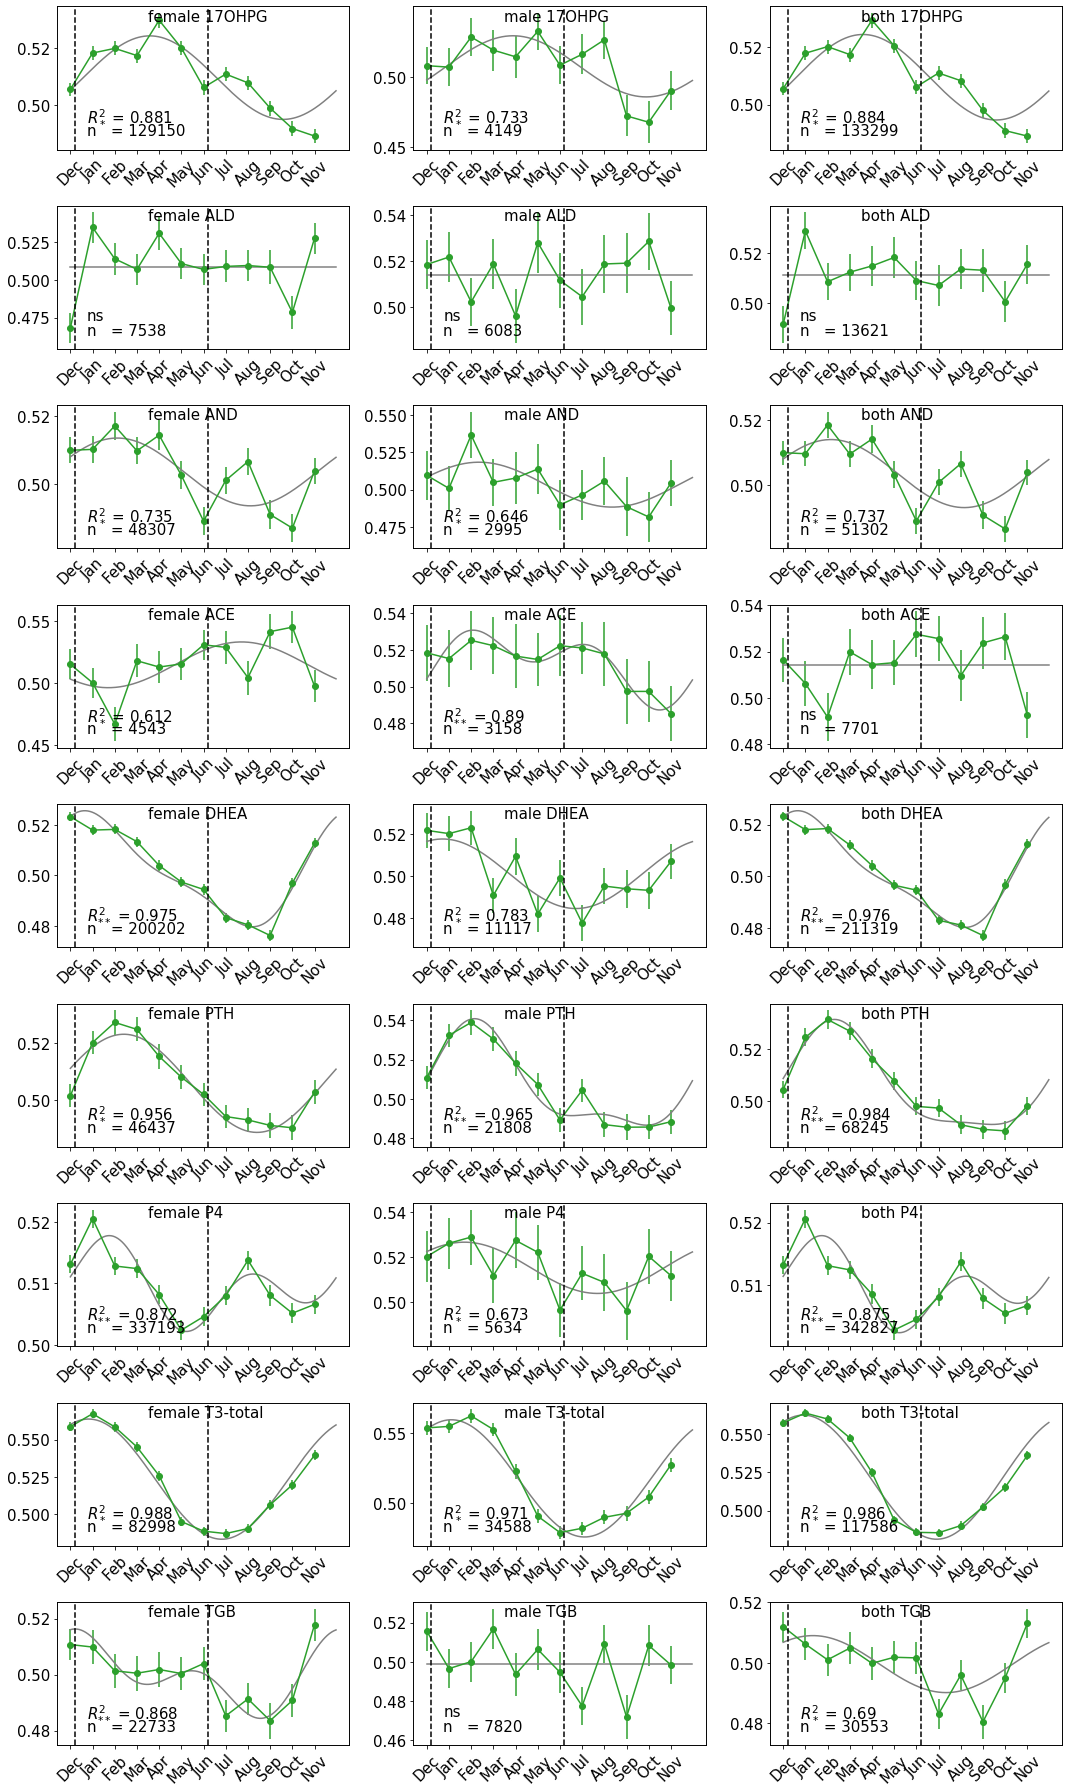

In [9]:
'''
plot residual hormones seasonality
'''
residual_r2df = pd.DataFrame(columns = ['sex','hormone','r2'])
plt.figure(figsize=(15,25))
for j,k in tqdm(enumerate(residual_hormone_dic.keys())):
    for i,sex in enumerate(['female','male','both']):        
        xloc    = residual_list[residual_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = residual_list[residual_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = residual_list[residual_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = residual_list[residual_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = residual_list[residual_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = residual_list[residual_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = residual_list[residual_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = residual_list[residual_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]

        if amp2 >0:
            rstr = '$R_{**}^2$'
        elif amp > 0:
            rstr = '$R_*^2$'
        else:
            rstr = 'ns'
        
        p        = ((phase)/12)*2*np.pi 
        p2       = ((phase2)/12)*2*np.pi
        
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        R2       = np.corrcoef(yloc,cosine2)[0,1]
        residual_r2df = residual_r2df.append(pd.DataFrame({'sex':sex,'hormone':k,'r2':[R2]}))

        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        #plot
        ax = plt.subplot(9,3,1+i +j*3)
        ax.errorbar(xloc,yloc,err,c=def_color[2],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-1],cosine2,c='gray')
        ax.set_xticks(np.arange(12))
        ax.set_xticklabels(np.roll(month_names,1), rotation=45,fontsize=15)
#         ax.set_ylabel(pituitary_unit_dict[residual_hormone_dic[k]],fontsize=15)
        ax.tick_params(axis="y", labelsize=15)
        axn = ax.twinx()
        axn.set_yticks([])
        axn.annotate('n   = '+str(ntot),(0.75,0.1),fontsize=15)
        if rstr == 'ns':
            axn.annotate(rstr,(0.75,0.2),fontsize=15)
        else:
            axn.annotate(rstr+' = '+str(np.round(R2,decimals=3)),(0.75,0.2),fontsize=15)
        axn.annotate(sex + ' ' + residual_hormone_dic[k],(3.5,0.9),fontsize=15,fontweight='roman')
        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')
         
plt.tight_layout()
# plt.savefig('../figures/Seasonality24112019/residual_subplots_1912_20_80.pdf',bbox_inches='tight',dpi=600)
plt.show()

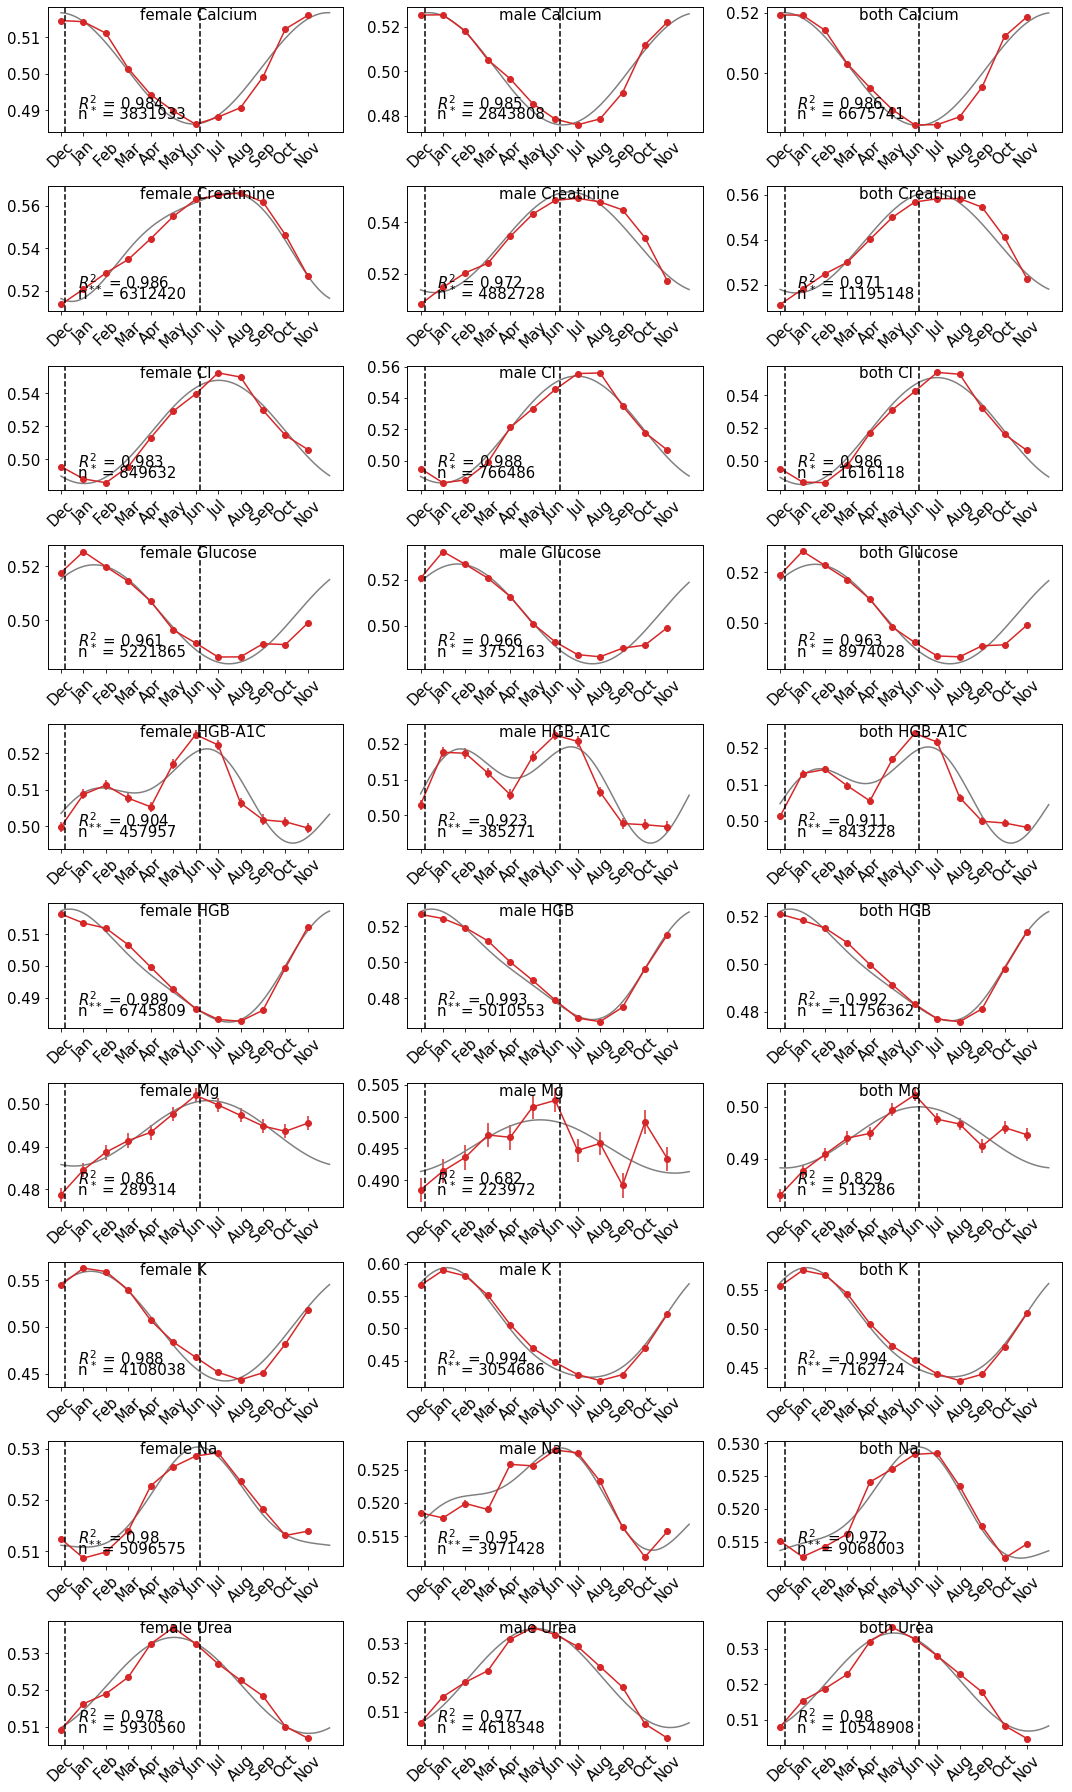

In [10]:
'''
plot chemistry seasonality
'''
chem_r2df = pd.DataFrame(columns = ['sex','hormone','r2'])
plt.figure(figsize=(15,25))
for j,k in tqdm(enumerate(chem_dic.keys())):
    for i,sex in enumerate(['female','male','both']):        
        xloc    = chem_list[chem_dic[k]][sex]['Clalit']['xloc']
        yloc    = chem_list[chem_dic[k]][sex]['Clalit']['yloc']
        err     = chem_list[chem_dic[k]][sex]['Clalit']['err']
        ntot    = chem_list[chem_dic[k]][sex]['Clalit']['ntot']
        phase   = chem_list[chem_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = chem_list[chem_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = chem_list[chem_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = chem_list[chem_dic[k]][sex]['Cosinor2']['pars'][0][1]

        if amp2 >0:
            rstr = '$R_{**}^2$'
        elif amp > 0:
            rstr = '$R_*^2$'
        else:
            rstr = 'ns'
        
        p        = ((phase)/12)*2*np.pi 
        p2       = ((phase2)/12)*2*np.pi
        
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        R2       = np.corrcoef(yloc,cosine2)[0,1]
        chem_r2df = chem_r2df.append(pd.DataFrame({'sex':sex,'hormone':k,'r2':[R2]}))

        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        #plot
        ax = plt.subplot(10,3,1+i +j*3)
        ax.errorbar(xloc,yloc,err,c=def_color[3],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-1],cosine2,c='gray')
        ax.set_xticks(np.arange(12))
        ax.set_xticklabels(np.roll(month_names,1), rotation=45,fontsize=15)
        ax.tick_params(axis="y", labelsize=15)
        axn = ax.twinx()
        axn.set_yticks([])
        axn.annotate('n   = '+str(ntot),(0.75,0.1),fontsize=15)
        if rstr == 'ns':
            axn.annotate(rstr,(0.75,0.2),fontsize=15)
        else:
            axn.annotate(rstr+' = '+str(np.round(R2,decimals=3)),(0.75,0.2),fontsize=15)
        axn.annotate(sex + ' ' + chem_dic[k],(3.5,0.9),fontsize=15,fontweight='roman')
        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')
       
plt.tight_layout()
# plt.savefig('../figures/Seasonality24112019/chemistry_subplots_1912_20_80.pdf',bbox_inches='tight',dpi=600)
plt.show()

# FIG 1 complete

In [82]:
xoff = 0.2
Yoff = 0.4 

def HPL_graph_on_axe(ax):
    
    ax.annotate('H'    ,[-1  +xoff   ,0.2 +Yoff],fontsize=20,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1  +xoff   ,-0.4+Yoff],fontsize=20,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('L'    ,[-1  +xoff   ,-1+Yoff],fontsize=20,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('GH'  ,[-0.85+xoff ,-0.65+Yoff],fontsize=20,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('IGF-1',[-0.9+xoff ,-1.6+Yoff],fontsize=20,fontweight='bold',xycoords='axes fraction',color=def_color[0])

    ax.annotate('',fontsize=20,
                xytext=[-0.94  +xoff , 0.15 +Yoff],
                xy    =[-0.94  +xoff ,-0.2 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='bold',
                arrowprops=dict(arrowstyle="simple",color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=20,
                xytext=[-0.94  +xoff , -0.45 +Yoff],
                xy    =[-0.94  +xoff ,-0.8 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='bold',
                arrowprops=dict(arrowstyle="simple",color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=20,
                xytext=[-0.95  +xoff , -1.05 +Yoff],
                xy    =[-0.8  +xoff ,-1.4 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='bold',
                arrowprops=dict(arrowstyle="simple",color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
def HPG_graph_on_axe(ax):
    
    ax.annotate('H'    ,[-1  +xoff   ,0.2 +Yoff],fontsize=20,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1  +xoff   ,-0.4+Yoff],fontsize=20,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('G'    ,[-1  +xoff   ,-1+Yoff],fontsize=20,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('LH'   ,[-0.85+xoff ,-0.75+Yoff],fontsize=20,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('FSH'  ,[-0.85+xoff ,-0.55+Yoff],fontsize=20,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('Test',[-0.9+xoff ,-1.6+Yoff],fontsize=20,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('E2'  ,[-1.25+xoff ,-1.6+Yoff],fontsize=20,fontweight='bold',xycoords='axes fraction',color=def_color[0])

    ax.annotate('',fontsize=20,
                xytext=[-0.94  +xoff , 0.15 +Yoff],
                xy    =[-0.94  +xoff ,-0.2 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='bold',
                arrowprops=dict(arrowstyle="simple",color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=20,
                xytext=[-0.94  +xoff , -0.45 +Yoff],
                xy    =[-0.94  +xoff ,-0.8 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='bold',
                arrowprops=dict(arrowstyle="simple",color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=20,
                xytext=[-0.95  +xoff , -1.05 +Yoff],
                xy    =[-0.8  +xoff ,-1.4 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='bold',
                arrowprops=dict(arrowstyle="simple",color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=20,
                xytext=[-0.95  +xoff , -1.05 +Yoff],
                xy    =[-1.1  +xoff ,-1.4 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='bold',
                arrowprops=dict(arrowstyle="simple",color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))


def HPT_graph_on_axe(ax):
    
    ax.annotate('H'    ,[-1  +xoff   ,0.2 +Yoff],fontsize=20,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1  +xoff   ,-0.4+Yoff],fontsize=20,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('T'    ,[-1  +xoff   ,-1+Yoff],fontsize=20,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('TSH'   ,[-0.85+xoff ,-0.65+Yoff],fontsize=20,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('T4',[-0.87+xoff ,-1.6+Yoff],fontsize=20,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('T3'  ,[-1.25+xoff ,-1.6+Yoff],fontsize=20,fontweight='bold',xycoords='axes fraction',color=def_color[0])

    ax.annotate('',fontsize=20,
                xytext=[-0.94  +xoff , 0.15 +Yoff],
                xy    =[-0.94  +xoff ,-0.2 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='bold',
                arrowprops=dict(arrowstyle="simple",color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=20,
                xytext=[-0.94  +xoff , -0.45 +Yoff],
                xy    =[-0.94  +xoff ,-0.8 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='bold',
                arrowprops=dict(arrowstyle="simple",color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=20,
                xytext=[-0.95  +xoff , -1.05 +Yoff],
                xy    =[-0.8  +xoff ,-1.4 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='bold',
                arrowprops=dict(arrowstyle="simple",color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=20,
                xytext=[-0.95  +xoff , -1.05 +Yoff],
                xy    =[-1.1  +xoff ,-1.4 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='bold',
                arrowprops=dict(arrowstyle="simple",color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    
def HPA_graph_on_axe(ax):
    
    ax.annotate('H'    ,[-1  +xoff   ,0.2 +Yoff],fontsize=20,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1  +xoff   ,-0.4+Yoff],fontsize=20,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('A'    ,[-1  +xoff   ,-1+Yoff],fontsize=20,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('ACTH'  ,[-0.85+xoff ,-0.65+Yoff],fontsize=20,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('Cort',[-0.9+xoff ,-1.6+Yoff],fontsize=20,fontweight='bold',xycoords='axes fraction',color=def_color[0])

    ax.annotate('',fontsize=20,
                xytext=[-0.94  +xoff , 0.15 +Yoff],
                xy    =[-0.94  +xoff ,-0.2 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='bold',
                arrowprops=dict(arrowstyle="simple",color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=20,
                xytext=[-0.94  +xoff , -0.45 +Yoff],
                xy    =[-0.94  +xoff ,-0.8 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='bold',
                arrowprops=dict(arrowstyle="simple",color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=20,
                xytext=[-0.95  +xoff , -1.05 +Yoff],
                xy    =[-0.8  +xoff ,-1.4 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='bold',
                arrowprops=dict(arrowstyle="simple",color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))

def PRL_graph_on_axe(ax):
    
    ax.annotate('H'    ,[-1  +xoff   ,0.2 +Yoff],fontsize=20,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1  +xoff   ,-0.4+Yoff],fontsize=20,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('PRL'  ,[-0.85+xoff + 0.1 ,-0.65+Yoff - 0.1],fontsize=20,fontweight='bold',xycoords='axes fraction',color=def_color[1])

    ax.annotate('',fontsize=20,
                xytext=[-0.94  +xoff , 0.15 +Yoff],
                xy    =[-0.94  +xoff ,-0.2 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='bold',
                arrowprops=dict(arrowstyle="simple",color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=20,
                xytext=[-0.94  +xoff , -0.45 +Yoff],
                xy    =[-0.94  +xoff + 0.2 ,-0.7 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='bold',
                arrowprops=dict(arrowstyle="simple",color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))
    

def plot_phase_amp(ax,amp_mean,phase_mean,amp_std,phase_std,names,color=def_color[0],loc_list=None,markersize=15,empty=False):
    if empty:
        ax.errorbar(phase_mean, amp_mean,ls='none',marker='.',xerr=phase_std,yerr=amp_std,color=color,markersize=markersize,fmt='o', mfc='white')
    else:
        ax.errorbar(phase_mean, amp_mean,ls='none',marker='.',xerr=phase_std,yerr=amp_std,color=color,markersize=markersize)
    if loc_list==None:
        loc_list=len(phase_mean)*[(0.015,0.001)]
    for i, txt in enumerate(names):   
        ax.annotate(txt, (phase_mean[i]+loc_list[i][0], amp_mean[i]+loc_list[i][1]),fontsize=15)
    

# Plotting

D:\Anaconda\envs\venv\lib\site-packages\ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
D:\Anaconda\envs\venv\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\Anaconda\envs\venv\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\Anaconda\envs\venv\lib\site-packages\ipykernel_launcher.py:112: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be

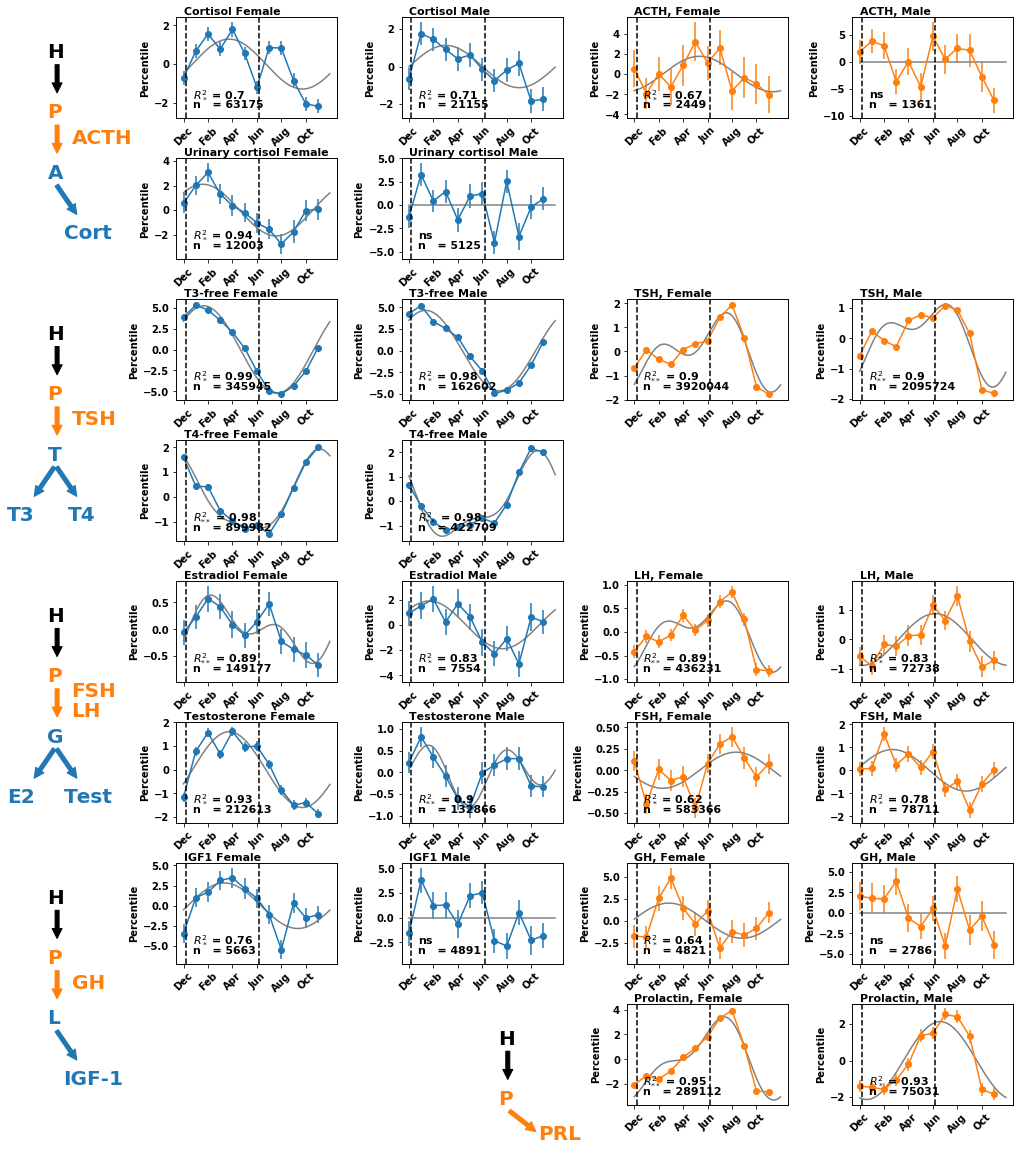

In [166]:
'''
FIG 1 -  Code to plot cosinor fit subplots
'''
plt.rcParams["font.weight"] = "bold"
fig = plt.figure(figsize=(15,20))
gs  = fig.add_gridspec(8, 4)
ax  = fig.add_subplot(gs[0,0]); HPA_graph_on_axe(ax)
ax  = fig.add_subplot(gs[2,0]); HPT_graph_on_axe(ax)
ax  = fig.add_subplot(gs[4,0]); HPG_graph_on_axe(ax)
ax  = fig.add_subplot(gs[6,0]); HPL_graph_on_axe(ax)
ax  = fig.add_subplot(gs[7,2]); PRL_graph_on_axe(ax)
month_names0  = np.roll(month_names,1)

for j,k in enumerate(effector_hormone_dic.keys()):
    for i,sex in enumerate(['female','male']):
        
        xloc    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = effector_list[effector_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = effector_list[effector_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = effector_list[effector_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = effector_list[effector_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = effector_list[effector_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]

        if amp2 >0:
            rstr = '$R_{**}^2$'
        elif amp > 0:
            rstr = '$R_*^2$'
        else:
            rstr = 'ns'
        
        p        = (phase/12)*2*np.pi
        p2       = (phase2/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        R2       = np.corrcoef(yloc,cosine2)[0,1]
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        data_percentile = (yloc-yloc.mean())*100
        fit_percentile  = (cosine2-cosine2.mean())*100
        #plot
        ax = fig.add_subplot(gs[j,i])
        ax.errorbar(xloc,data_percentile,err*100,c=def_color[0],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-1],fit_percentile,c='gray')
        ax.set_xticks(np.arange(0,12,2))
        ax.set_xticklabels(month_names0[::2], rotation=45,fontsize=10,fontweight='bold')
        ax.set_ylabel(effector_unit_dict[effector_hormone_dic[k]],fontsize=10,fontweight='bold')
        ax.tick_params(axis="y", labelsize=10)

        axn = ax.twinx()
        axn.set_yticks([])
        axn.annotate('n   = '+str(ntot),(0.75,0.1),fontsize=11)
        if rstr == 'ns':
            axn.annotate(rstr,(0.75,0.2),fontsize=11)
        else:
            axn.annotate(rstr+' = '+str(np.round(R2,decimals=2)),(0.75,0.2),fontsize=11)
        axn.annotate(effector_hormone_dic[k] + ' ' + sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=11,fontweight='bold')
        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')
             
PIT_ORDER = [0,2,4,5,6,7]
for j,k in enumerate(pituitary_hormone_dic.keys()):
    for i,sex in enumerate(['female','male']):
        
        xloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]

        if amp2 >0:
            rstr = '$R_{**}^2$'
        elif amp > 0:
            rstr = '$R_*^2$'
        else:
            rstr = 'ns'    
        p        = (phase/12)*2*np.pi
        p2       = (phase2/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        R2       = np.corrcoef(yloc,cosine2)[0,1]
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        data_percentile = (yloc-yloc.mean())*100
        fit_percentile  = (cosine2-cosine2.mean())*100
        #plot
        ax = fig.add_subplot(gs[PIT_ORDER[j],i+2])
        ax.errorbar(xloc,data_percentile,err*100,c=def_color[1],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-1],fit_percentile,c='gray')
        ax.set_xticks(np.arange(0,12,2))
        ax.set_xticklabels(month_names0[::2], rotation=45,fontsize=10,fontweight='bold')
        ax.set_ylabel(pituitary_unit_dict[pituitary_hormone_dic[k]],fontsize=10,fontweight='bold')        
        ax.tick_params(axis="y", labelsize=10)

        axn = ax.twinx()
        axn.set_yticks([])
        axn.annotate('n   = '+str(ntot),(0.75,0.1),fontsize=11)
        if rstr == 'ns':
            axn.annotate(rstr,(0.75,0.2),fontsize=11)
        else:
            axn.annotate(rstr+' = '+str(np.round(R2,decimals=2)),(0.75,0.2),fontsize=11)
        axn.annotate(pituitary_hormone_dic[k] + ', ' + sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=11,fontweight='bold')
        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')
        
plt.subplots_adjust(hspace=0.4,wspace =0.4)
# plt.savefig('../figures/Seasonality06012020/Figure1_0601_20_80.pdf',bbox_inches='tight',dpi=600)
plt.show()

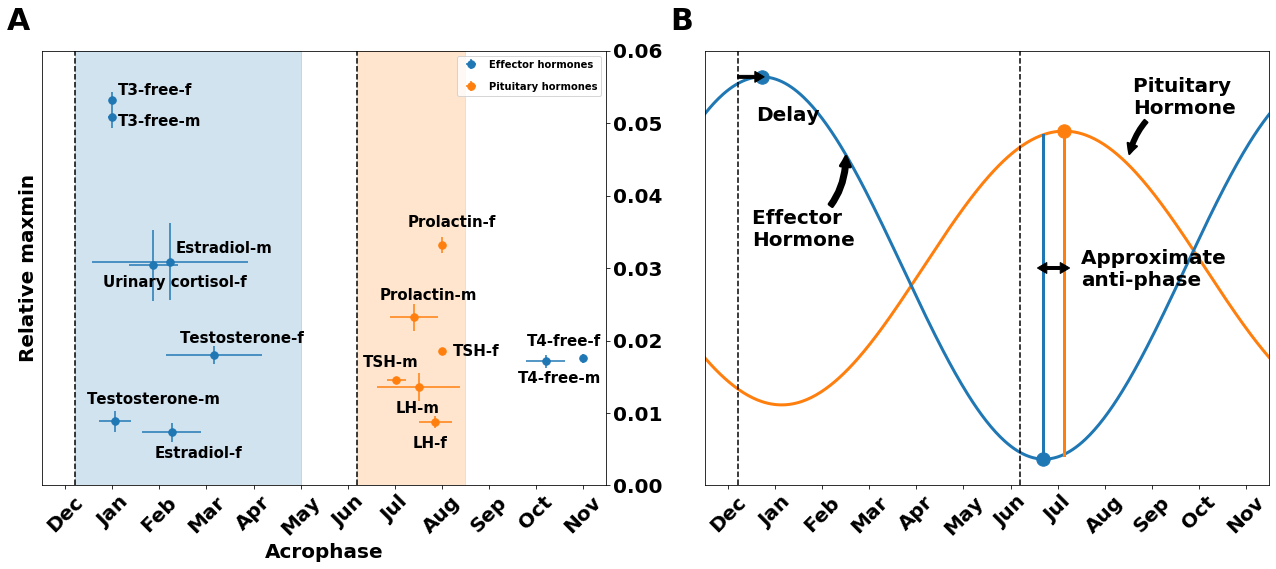

In [165]:
'''
FIG 2AB -  Code to phase plot, and summery
'''
plt.rcParams["font.weight"] = "bold"
fig = plt.figure(figsize=(22,8))
gs  = fig.add_gridspec(4, 6)

uy = 0.06/100
ux = 12/100
pit_loc = [(2*ux,-uy),(-6*ux,3*uy),(-4*ux,-6*uy),(-4*ux,-6*uy),(-6*ux,4*uy),(-6*ux,4*uy)]
eff_loc = [(-9*ux,-5*uy),(ux,uy),(ux,-2*uy),(-10*ux,3*uy),(-5*ux,-5*uy),(-3*ux,-6*uy),(ux,2*uy),(-6*ux,3*uy),(-5*ux,4*uy)]

temp    = eff_r2df.loc[eff_r2df['sex']!='both']
temp    = temp[temp['r2']>0.8]
eff_big = [[temp.iloc[i]['hormone'],temp.iloc[i]['sex']] for i in range(len(temp))]

temp    = pit_r2df.loc[pit_r2df['sex']!='both']
temp    = temp[temp['r2']>0.8]
pit_big = [[temp.iloc[i]['hormone'],temp.iloc[i]['sex']] for i in range(len(temp))]

eff_rel_maxmin     = []
eff_acrophase      = []
eff_rel_maxmin_std = []
eff_acrophase_std  = []
eff_names          = []

for hormone in eff_big:
    name = hormone[0]
    sex  = hormone[1]
    sex_one_letter = sex[0]
    eff_rel_maxmin    .append(effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][3])
    eff_acrophase     .append(effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][2])
    eff_rel_maxmin_std.append(effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][1][3])
    eff_acrophase_std .append(effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][1][2])
    eff_names         .append(effector_hormone_dic[name] +"-"+ sex_one_letter)

pit_rel_maxmin     = []
pit_acrophase      = []
pit_rel_maxmin_std = []
pit_acrophase_std  = []
pit_names          = []

for hormone in pit_big:
    name = hormone[0]
    if name == 'GROWTH_HORMONE_GH':
        continue    
    sex  = hormone[1]
    if name == 'FSH_FOLLICLE_STIMULATING_HORMONE':
        if sex =='male':
            continue
    sex_one_letter = sex[0]
    pit_rel_maxmin    .append(pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][3])
    pit_acrophase     .append(pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][2])
    pit_rel_maxmin_std.append(pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][1][3])
    pit_acrophase_std .append(pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][1][2])
    pit_names         .append(pituitary_hormone_dic[name]+ '-'+ sex_one_letter)


'''
FIG 2A -  Code to plot phase/amp 
'''
axbig = fig.add_subplot(gs[:,:3])
ax    = fig.add_subplot(gs[:,3:])

plot_phase_amp(axbig,
               np.array(eff_rel_maxmin),
               np.array(eff_acrophase), 
               np.array(eff_rel_maxmin_std),
               np.array(eff_acrophase_std),
               eff_names,
               color=def_color[0],
               loc_list=eff_loc)

plot_phase_amp(axbig,
               np.array(pit_rel_maxmin),
               np.array(pit_acrophase), 
               np.array(pit_rel_maxmin_std),
               np.array(pit_acrophase_std),
               pit_names,
               color=def_color[1],
               loc_list=pit_loc)

month_names0  = np.roll(month_names,1)
axbig.legend(['Effector hormones','Pituitary hormones'],loc=1,fontsize='medium',labelspacing =1.2)#,bbox_to_anchor=(1,0.83))
axbig.xaxis.set_major_locator(ticker.IndexLocator(base=1,offset=0.5))
axbig.yaxis.tick_right()
# axbig.tick_params(which='minor', length=8,labelsize =20)
# axbig.tick_params(which='major', length=0,labelsize =20)
axbig.set_ylim((0,0.06))
axbig.set_ylabel('Relative maxmin',fontdict={'size': 20,'fontweight':'bold'})
axbig.set_xlabel('Acrophase'        ,fontdict={'size': 20,'fontweight':'bold'})
axbig.set_xlim([-0.5,11.5])
axbig.text(-0.02, 1.1, 'A', transform=axbig.transAxes,fontsize = 30, fontweight='bold', va='top', ha='right')

axbig.set_xticks(np.arange(12))
axbig.set_xticklabels(month_names0, rotation=45)
axbig.tick_params(axis='x',labelsize =20)
axbig.tick_params(axis='y',labelsize =20)

axbig.axvline(x=0.2,ls='--',c='k')
axbig.axvspan(0.2, 5  , alpha=0.2, color=def_color[0])
axbig.axvline(x=6.2,ls='--',c='k')
axbig.axvspan(6.2, 8.5, alpha=0.2, color=def_color[1])

###########################################
###########################################
###########################################

'''
FIG 2B -  Code to calculate average effector hormones seasonality
'''
stack_eff_cos = []
stack_pit_cos = []

for j,hormone in enumerate(eff_big):
    name = hormone[0]
    sex  = hormone[1]
    acrophase = effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][2]
    relmaxmin = effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][3]
    stack_eff_cos.append([acrophase,relmaxmin])
    
for j,hormone in enumerate(pit_big):
    name = hormone[0]
    if name == 'GROWTH_HORMONE_GH':
        continue    
    sex  = hormone[1]
    if name == 'FSH_FOLLICLE_STIMULATING_HORMONE':
        if sex =='male':
            continue
    acrophase = pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][2]
    relmaxmin = pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][3]
    stack_pit_cos.append([acrophase,relmaxmin])

p         = circmean(np.array(stack_pit_cos)[:,0],high=12, low=0)*2*np.pi/12
relmaxmin =  np.mean(np.array(stack_pit_cos)[:,1])   
pit_cos   = 1+relmaxmin*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
pit_cos   = np.insert(pit_cos, 365, pit_cos[0])

p         = circmean(np.array(stack_eff_cos)[:,0],high=12, low=0)*2*np.pi/12
relmaxmin =  np.mean(np.array(stack_eff_cos)[:,1])     
eff_cos   = 1+relmaxmin*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
eff_cos   = np.insert(eff_cos, 365, eff_cos[0])

# vector of 12 months, smoothed by interpolation
ax.plot(np.arange(0,12,12/365),pit_cos,color=def_color[1],linewidth = 3)
ax.plot(np.arange(0,12,12/365),eff_cos,color=def_color[0],linewidth = 3)

mn = np.roll(month_names,1)
mn = np.insert(mn, 12, mn[0])
ax.set_yticks([])

ax.set_xticks(0.5+np.arange(12))
ax.set_xticklabels(mn, rotation=45)
ax.set_xlim([0,12])
ax.tick_params(axis='x',labelsize =20)

ax.arrow(0.7, eff_cos.max(), eff_cos.argmax()*12/365-0.85, 0,head_width=0.0015, head_length=0.2 , width=0.0004, fc='k', ec='k', zorder=4)
ax.annotate('Delay',[1.1,1.02],fontsize=20)

ax.annotate('Pituitary \nHormone',fontsize=20,
            xy=(9, pit_cos[9*30]), xycoords='data',
            xytext=(9.1, 1.021), textcoords='data',
            arrowprops=dict(arrowstyle="simple",
                            color="0",
                            shrinkB=5,linewidth = 2,
                            connectionstyle="arc3,rad=0.3"),)

ax.annotate('Effector \nHormone',fontsize=20,
            xy=(3, eff_cos[3*30]), xycoords='data',
            xytext=(1, 1.003), textcoords='data',
            arrowprops=dict(arrowstyle="simple",
                            color="0",
                            shrinkB=5,linewidth = 3,
                            connectionstyle="arc3,rad=0.3"),)

ax.scatter(eff_cos.argmax()*12/365, eff_cos.max(),s=180,c=def_color[0])
ax.scatter(eff_cos.argmin()*12/365, eff_cos.min(),s=180,c=def_color[0])
ax.scatter(pit_cos.argmax()*12/365, pit_cos.max(),s=180,c=def_color[1])

ax.plot([pit_cos.argmax()*12/365,pit_cos.argmax()*12/365],[pit_cos.max(),eff_cos[pit_cos.argmax()]],c=def_color[1],lw='3')
ax.plot([eff_cos.argmin()*12/365,eff_cos.argmin()*12/365],[eff_cos.min(),pit_cos[eff_cos.argmin()]],c=def_color[0],lw='3')

ax.annotate('Approximate \nanti-phase',[8,0.9975],fontsize=20)

mid    = np.mean([pit_cos.argmax()*12/365,eff_cos.argmin()*12/365])
ar_len = np.diff([pit_cos.argmax()*12/365,eff_cos.argmin()*12/365])[0]/3

ax.arrow(mid, 1, ar_len, 0, head_width=0.0015, head_length=0.2 , width=0.0004, fc='k', ec='k', zorder=4)
ax.arrow(mid, 1, -ar_len, 0, head_width=0.0015, head_length=0.2 , width=0.0004, fc='k', ec='k', zorder=4)

ax.text(-0.02, 1.1, 'B', transform=ax.transAxes,fontsize = 30, fontweight='bold', va='top', ha='right')
ax.axvline(x=0.7,ls='--',c='k')
ax.axvline(x=6.7,ls='--',c='k')

plt.subplots_adjust(hspace=0.4,wspace =0.8)
plt.savefig('../figures/Seasonality06012020/Figure2AB_0601_20_80_selected.pdf',bbox_inches='tight',dpi=600)
plt.show()

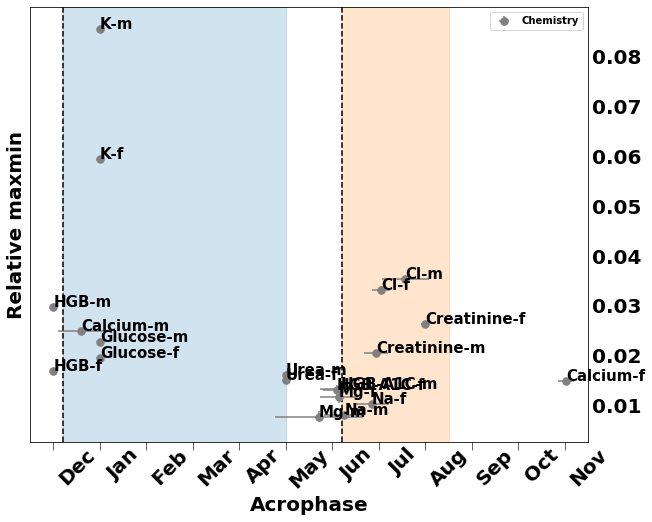

In [113]:
temp    = chem_r2df.loc[chem_r2df['sex']!='both']
temp    = temp[temp['r2']>0.4]
chem_big = [[temp.iloc[i]['hormone'],temp.iloc[i]['sex']] for i in range(len(temp))]
chem_loc = [(0,0) for chem in chem_big]

chem_rel_maxmin     = []
chem_acrophase      = []
chem_rel_maxmin_std = []
chem_acrophase_std  = []
chem_names          = []

for hormone in chem_big:
    name = hormone[0]
    sex  = hormone[1]
    sex_one_letter = sex[0]
    chem_rel_maxmin    .append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][0][3])
    chem_acrophase     .append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][0][2])
    chem_rel_maxmin_std.append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][1][3])
    chem_acrophase_std .append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][1][2])
    chem_names         .append(chem_dic[name] +"-"+ sex_one_letter)
    
plt.figure(figsize = (10,8))   
axbig = plt.subplot(1,1,1)
    
plot_phase_amp(axbig,
           np.array(chem_rel_maxmin),
           np.array(chem_acrophase), 
           np.array(chem_rel_maxmin_std),
           np.array(chem_acrophase_std),
           chem_names,
           color='gray',
           loc_list=chem_loc)

month_names0  = np.roll(month_names,1)
axbig.legend(['Chemistry'],loc=1,fontsize='medium',labelspacing =1.2)#,bbox_to_anchor=(1,0.83))
axbig.xaxis.set_major_locator(ticker.IndexLocator(base=1,offset=0.5))
axbig.yaxis.tick_right()
axbig.tick_params(which='minor', length=8,labelsize =20)
axbig.tick_params(which='major', length=0,labelsize =20)
# axbig.set_ylim((0,0.06))
axbig.set_ylabel('Relative maxmin',fontdict={'size': 20,'fontweight':'bold'})
axbig.set_xlabel('Acrophase'        ,fontdict={'size': 20,'fontweight':'bold'})
axbig.set_xticks(np.arange(12),minor=True)

axbig.set_xticklabels(month_names0, rotation=45)
axbig.set_xlim([-0.5,11.5])

axbig.axvline(x=0.2,ls='--',c='k')
axbig.axvspan(0.2, 5  , alpha=0.2, color=def_color[0])
axbig.axvline(x=6.2,ls='--',c='k')
axbig.axvspan(6.2, 8.5, alpha=0.2, color=def_color[1])
plt.savefig('../figures/Seasonality24112019/Chem_phase_amp_1912_20_80.pdf',bbox_inches='tight',dpi=600)
plt.show()

D:\Anaconda\envs\venv\lib\site-packages\ipykernel_launcher.py:227: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
D:\Anaconda\envs\venv\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\Anaconda\envs\venv\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\Anaconda\envs\venv\lib\site-packages\ipykernel_launcher.py:278: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can b

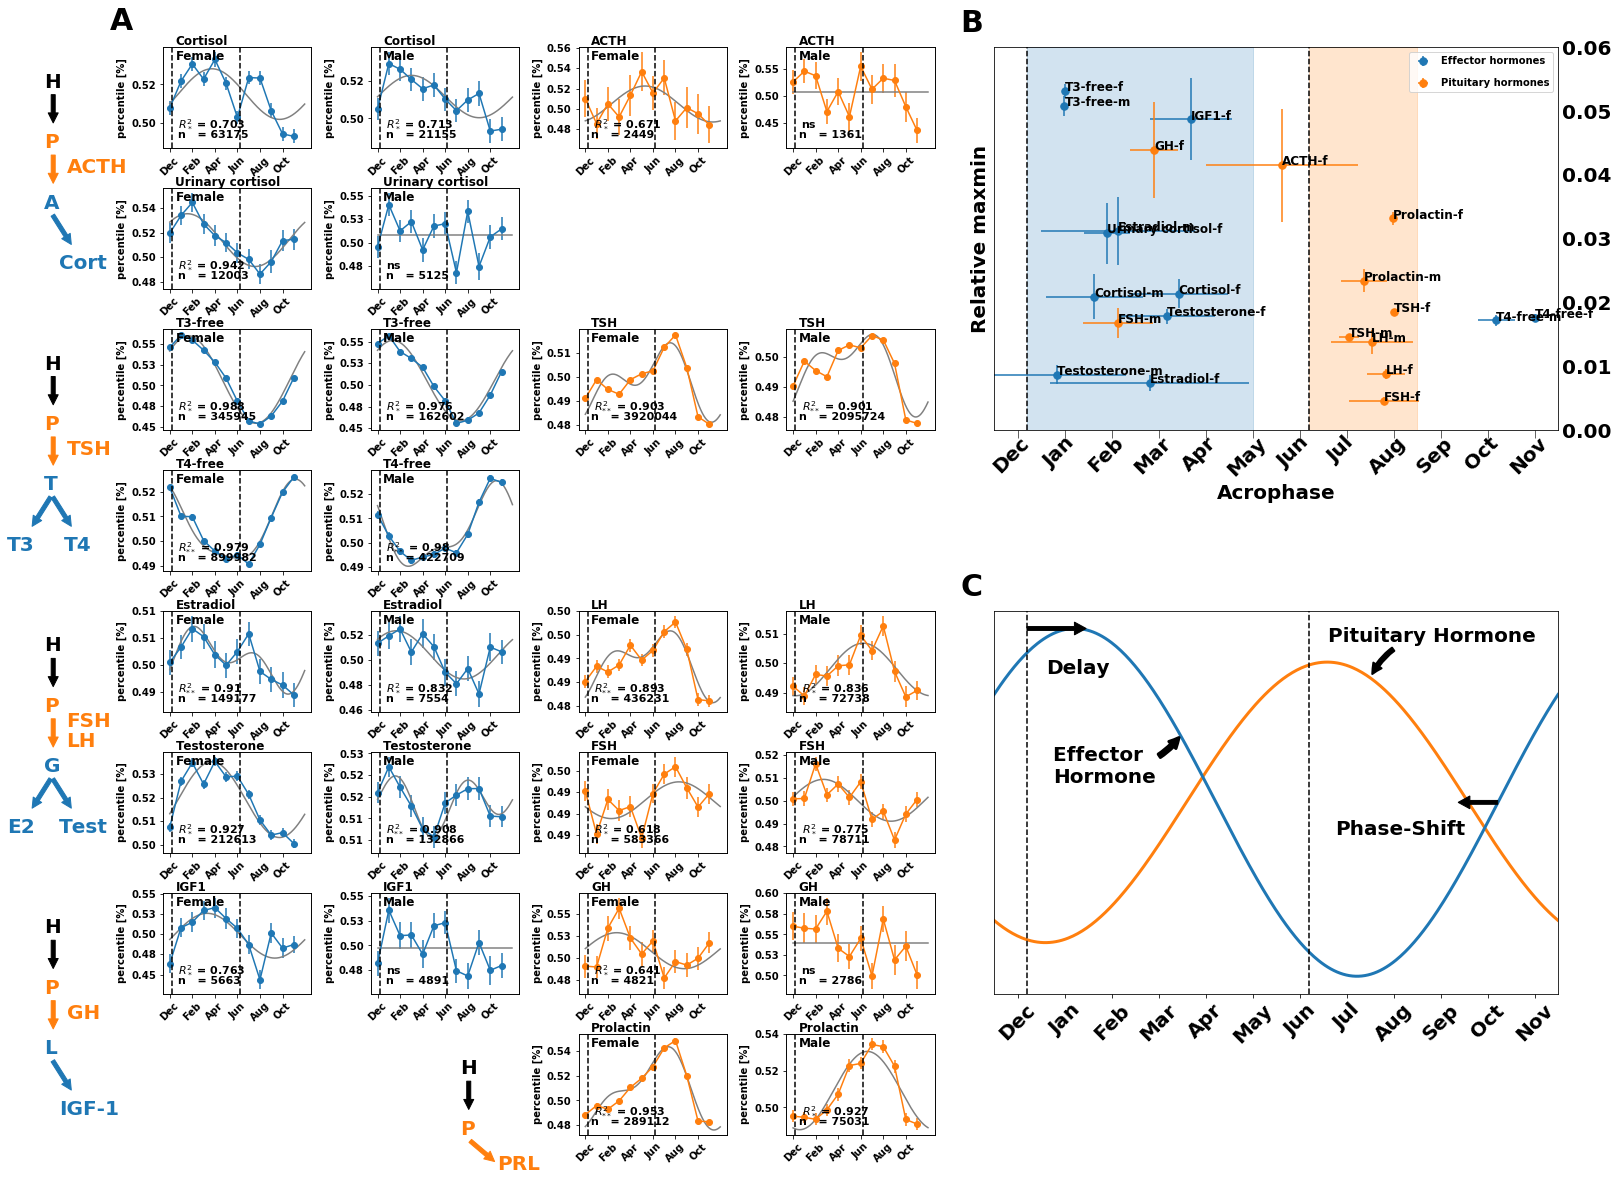

In [53]:
temp    = eff_r2df.loc[eff_r2df['sex']!='both']
temp    = temp[temp['r2']>0.1]
eff_big = [[temp.iloc[i]['hormone'],temp.iloc[i]['sex']] for i in range(len(temp))]
eff_loc = [(0,0) for eff in eff_big]

temp    = pit_r2df.loc[pit_r2df['sex']!='both']
temp    = temp[temp['r2']>0.1]
pit_big = [[temp.iloc[i]['hormone'],temp.iloc[i]['sex']] for i in range(len(temp))]
pit_loc = [(0,0) for eff in eff_big]

eff_rel_maxmin     = []
eff_acrophase      = []
eff_rel_maxmin_std = []
eff_acrophase_std  = []
eff_names          = []

for hormone in eff_big:
    name = hormone[0]
    sex  = hormone[1]
    sex_one_letter = sex[0]
    eff_rel_maxmin    .append(effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][3])
    eff_acrophase     .append(effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][2])
    eff_rel_maxmin_std.append(effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][1][3])
    eff_acrophase_std .append(effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][1][2])
    eff_names         .append(effector_hormone_dic[name] +"-"+ sex_one_letter)

pit_rel_maxmin     = []
pit_acrophase      = []
pit_rel_maxmin_std = []
pit_acrophase_std  = []
pit_names          = []

for hormone in pit_big:
    name = hormone[0]
    sex  = hormone[1]
    sex_one_letter = sex[0]
    pit_rel_maxmin    .append(pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][3])
    pit_acrophase     .append(pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][2])
    pit_rel_maxmin_std.append(pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][1][3])
    pit_acrophase_std .append(pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][1][2])
    pit_names         .append(pituitary_hormone_dic[name]+ '-'+ sex_one_letter)

###########################################
plt.rcParams["font.weight"] = "bold"
fig = plt.figure(figsize=(25,20))
gs  = fig.add_gridspec(8, 7)
###########################################

'''
FIG 1B -  Code to plot phase/amp 
'''
axbig = fig.add_subplot(gs[0:3,4:])
ax    = fig.add_subplot(gs[4:-1,4:])

plot_phase_amp(axbig,
               np.array(eff_rel_maxmin),
               np.array(eff_acrophase), 
               np.array(eff_rel_maxmin_std),
               np.array(eff_acrophase_std),
               eff_names,
               color=def_color[0],
               loc_list=eff_loc)

plot_phase_amp(axbig,
               np.array(pit_rel_maxmin),
               np.array(pit_acrophase), 
               np.array(pit_rel_maxmin_std),
               np.array(pit_acrophase_std),
               pit_names,
               color=def_color[1],
               loc_list=pit_loc)

month_names0  = np.roll(month_names,1)
axbig.legend(['Effector hormones','Pituitary hormones'],loc=1,fontsize='medium',labelspacing =1.2)#,bbox_to_anchor=(1,0.83))
axbig.xaxis.set_major_locator(ticker.IndexLocator(base=1,offset=0.5))
axbig.yaxis.tick_right()
axbig.tick_params(which='minor', length=8,labelsize =20)
axbig.tick_params(which='major', length=0,labelsize =20)
axbig.set_ylim((0,0.06))
axbig.set_ylabel('Relative maxmin',fontdict={'size': 20,'fontweight':'bold'})
axbig.set_xlabel('Acrophase'        ,fontdict={'size': 20,'fontweight':'bold'})
axbig.set_xlim([0,12])
axbig.text(-0.02, 1.1, 'B', transform=axbig.transAxes,fontsize = 30, fontweight='bold', va='top', ha='right')

axbig.set_xticks(np.arange(12),minor=True)
# axbig.set_xticks(np.array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5 ])-0.5)
# axbig.set_xticks(np.arange(13))

axbig.set_xticklabels(month_names0, rotation=45)
axbig.set_xlim([-0.5,11.5])

axbig.axvline(x=0.2,ls='--',c='k')
axbig.axvspan(0.2, 5  , alpha=0.2, color=def_color[0])
axbig.axvline(x=6.2,ls='--',c='k')
axbig.axvspan(6.2, 8.5, alpha=0.2, color=def_color[1])
###########################################
###########################################
###########################################

'''
FIG 1C -  Code to calculate average effector hormones seasonality
'''
stack_eff_cos = []
stack_pit_cos = []

for j,hormone in enumerate(eff_big):
    name = hormone[0]
    sex  = hormone[1]
    acrophase = effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][2]
    relmaxmin = effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][3]
    stack_eff_cos.append([acrophase,relmaxmin])
    
for j,hormone in enumerate(pit_big):
    name = hormone[0]  
    sex  = hormone[1]
    acrophase = pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][2]
    relmaxmin = pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][3]
    stack_pit_cos.append([acrophase,relmaxmin])

p         = circmean(np.array(stack_pit_cos)[:,0],high=12, low=0)*2*np.pi/12
relmaxmin =  np.mean(np.array(stack_pit_cos)[:,1])   
pit_cos   = 1+relmaxmin*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
pit_cos   = np.insert(pit_cos, 365, pit_cos[0])

p         = circmean(np.array(stack_eff_cos)[:,0],high=12, low=0)*2*np.pi/12
relmaxmin =  np.mean(np.array(stack_eff_cos)[:,1])     
eff_cos   = 1+relmaxmin*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
eff_cos   = np.insert(eff_cos, 365, eff_cos[0])

# vector of 12 months, smoothed by interpolation
ax.plot(np.arange(0,12,12/365),pit_cos,color=def_color[1],linewidth = 3)
ax.plot(np.arange(0,12,12/365),eff_cos,color=def_color[0],linewidth = 3)

mn = np.roll(month_names,1)
mn = np.insert(mn, 12, mn[0])
ax.set_yticks([])
ax.set_xticks(0.5+np.arange(12))
# ax.set_ylim([1-0.02,1+0.02])
ax.set_xlim([0,12])
ax.set_xticklabels(mn, rotation=45)
ax.tick_params(axis='x',labelsize =20)

ax.arrow(((eff_cos-1)**2).argmin()*12/365,1,(((pit_cos-1)**2).argmin()*12/365-((eff_cos-1)**2).argmin()*12/365)*0.95,0,
         head_width=0.002, head_length=0.25 , width=0.0006, fc='k', ec='k', zorder=4)
ax.annotate('Phase-Shift',[7.25,0.995],fontsize=20)


ax.arrow(0.7, eff_cos.max(), eff_cos.argmax()*12/365-0.7, 0       ,  head_width=0.002, head_length=0.25 , width=0.0006, fc='k', ec='k', zorder=4)
ax.annotate('Delay',[1.1,1.02],fontsize=20)

ax.annotate('Pituitary Hormone',fontsize=20,
            xy=(8, pit_cos[int(8*30.5)]), xycoords='data',
            xytext=(7.1, 1.025), textcoords='data',
            arrowprops=dict(arrowstyle="simple",
                            color="0",
                            shrinkB=5,linewidth = 2,
                            connectionstyle="arc3,rad=0.3"),)

ax.annotate('Effector \nHormone',fontsize=20,
            xy=(4, eff_cos[4*30]), xycoords='data',
            xytext=(1.25, 1.003), textcoords='data',
            arrowprops=dict(arrowstyle="simple",
                            color="0",
                            shrinkB=5,linewidth = 3,
                            connectionstyle="arc3,rad=0.3"),)

ax.text(-0.02, 1.1, 'C', transform=ax.transAxes,fontsize = 30, fontweight='bold', va='top', ha='right')
ax.axvline(x=0.7,ls='--',c='k')
ax.axvline(x=6.7,ls='--',c='k')

# plt.tight_layout()
# plt.savefig('../figures/Seasonality24112019/Figure1BC_2411.pdf',bbox_inches='tight',dpi=600)
# plt.show()

##########################################
##########################################
##########################################
'''
FIG 1A -  Code to plot cosinor fit subplots
'''
ax  = fig.add_subplot(gs[0,0])
ax.text(-0.2, 1.4, 'A', transform=ax.transAxes,fontsize = 30, fontweight='bold', va='top', ha='right')
HPA_graph_on_axe(ax)

ax  = fig.add_subplot(gs[2,0])
HPT_graph_on_axe(ax)

ax  = fig.add_subplot(gs[4,0])
HPG_graph_on_axe(ax)

ax  = fig.add_subplot(gs[6,0])
HPL_graph_on_axe(ax)

ax  = fig.add_subplot(gs[7,2])
PRL_graph_on_axe(ax)

for j,k in enumerate(effector_hormone_dic.keys()):
    for i,sex in enumerate(['female','male']):
        
        xloc    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = effector_list[effector_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = effector_list[effector_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = effector_list[effector_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = effector_list[effector_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = effector_list[effector_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]

        if amp2 >0:
            rstr = '$R_{**}^2$'
        elif amp > 0:
            rstr = '$R_*^2$'
        else:
            rstr = 'ns'
        
        p        = (phase/12)*2*np.pi
        p2       = (phase2/12)*2*np.pi
        
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        R2       = np.corrcoef(yloc,cosine2)[0,1]
        
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        #plot
        ax = fig.add_subplot(gs[j,i])
        ax.errorbar(xloc,yloc,err,c=def_color[0],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-1],cosine2,c='gray')
        ax.set_xticks(np.arange(0,12,2))
        ax.set_xticklabels(month_names0[::2], rotation=45,fontsize=10,fontweight='bold')
        ax.set_ylabel(effector_unit_dict[effector_hormone_dic[k]],fontsize=10,fontweight='bold')
        ax.tick_params(axis="y", labelsize=10)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

        axn = ax.twinx()
        axn.set_yticks([])
        axn.annotate('n   = '+str(ntot),(0.75,0.1),fontsize=11)
        if rstr == 'ns':
            axn.annotate(rstr,(0.75,0.2),fontsize=11)
        else:
            axn.annotate(rstr+' = '+str(np.round(R2,decimals=3)),(0.75,0.2),fontsize=11)
        axn.annotate( effector_hormone_dic[k] + '\n' +sex.capitalize() ,(0.5,0.875),fontsize=12,fontweight='bold')
        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')

PIT_ORDER = [0,2,4,5,6,7]
for j,k in enumerate(pituitary_hormone_dic.keys()):
    for i,sex in enumerate(['female','male']):
        
        xloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]

        if amp2 >0:
            rstr = '$R_{**}^2$'
        elif amp > 0:
            rstr = '$R_*^2$'
        else:
            rstr = 'ns'
            
        p        = (phase/12)*2*np.pi
        p2       = (phase2/12)*2*np.pi
        
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        R2       = np.corrcoef(yloc,cosine2)[0,1]
        
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        #plot
        ax = fig.add_subplot(gs[PIT_ORDER[j],i+2])
        ax.errorbar(xloc,yloc,err,c=def_color[1],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-1],cosine2,c='gray')
        ax.set_xticks(np.arange(0,12,2))
        ax.set_xticklabels(month_names0[::2], rotation=45,fontsize=10,fontweight='bold')
        ax.set_ylabel(pituitary_unit_dict[pituitary_hormone_dic[k]],fontsize=10,fontweight='bold')        
        ax.tick_params(axis="y", labelsize=10)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

        axn = ax.twinx()
        axn.set_yticks([])
        axn.annotate('n   = '+str(ntot),(0.5,0.1),fontsize=11)
        if rstr == 'ns':
            axn.annotate(rstr,(0.75,0.2),fontsize=11)
        else:
            axn.annotate(rstr+' = '+str(np.round(R2,decimals=3)),(0.75,0.2),fontsize=11)
        axn.annotate(pituitary_hormone_dic[k] + '\n' +sex.capitalize()  ,(0.5,0.875),fontsize=12,fontweight='bold')
        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')

plt.subplots_adjust(hspace=0.4,wspace =0.4)
plt.savefig('../figures/Seasonality24112019/Figure1ABC_0501_all_20_80.pdf',bbox_inches='tight',dpi=600)
plt.show()

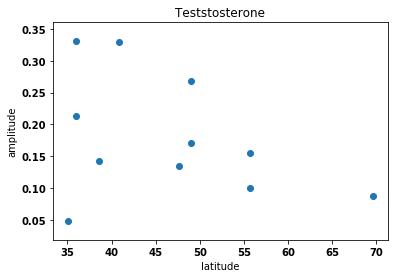

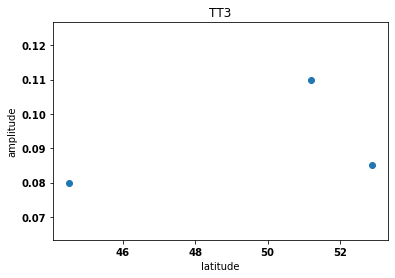

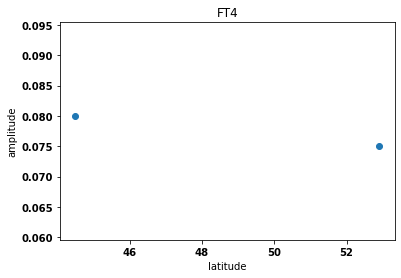

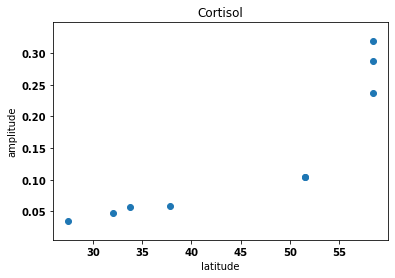

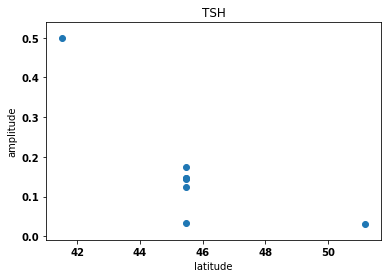

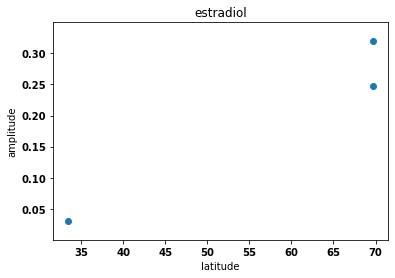

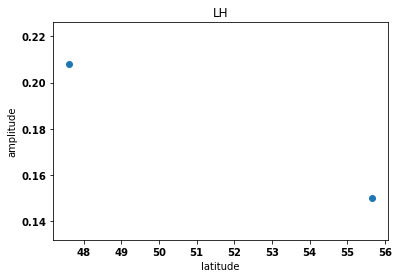

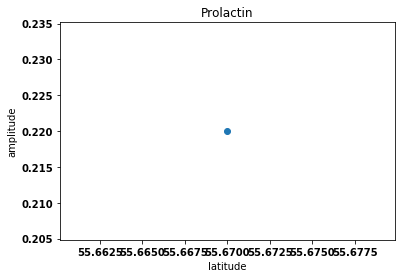

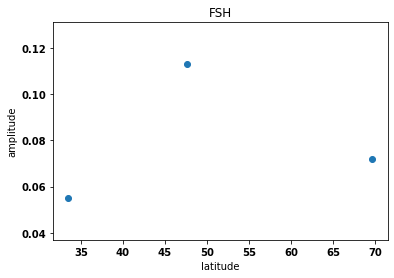

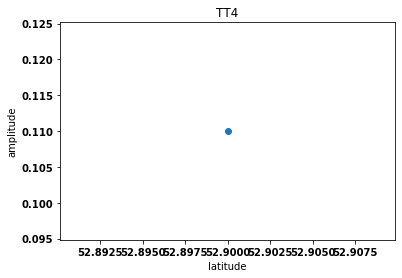

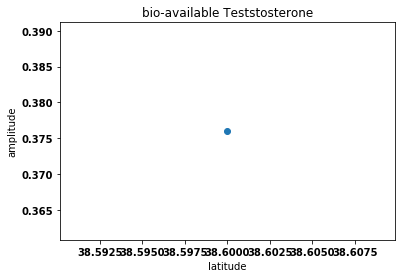

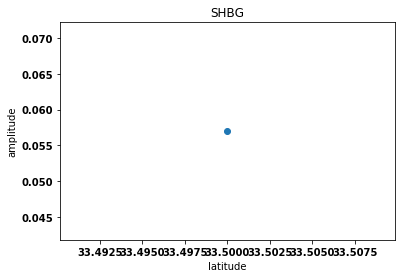

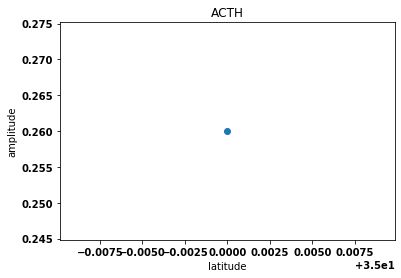

In [12]:
df = pd.read_excel('../HP seasonality review.xlsx')
df = df[['SEX','Hormone','latitude','amplitude']].copy()
df = df.loc[df['Hormone'] != '-']
df = df.dropna()

for hormone in list(set(df['Hormone'])):

    hdf = df.loc[df['Hormone']==hormone].copy()
    plt.scatter(np.abs(hdf['latitude'].values),hdf['amplitude'].values)
    plt.title(hormone)
    plt.xlabel('latitude')
    plt.ylabel('amplitude')
    plt.show()

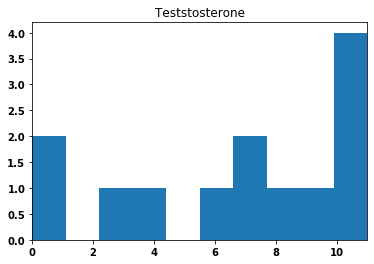

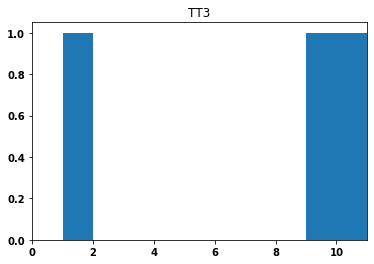

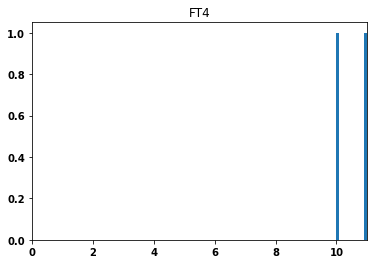

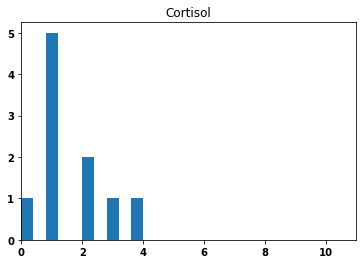

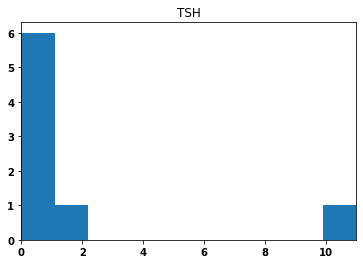

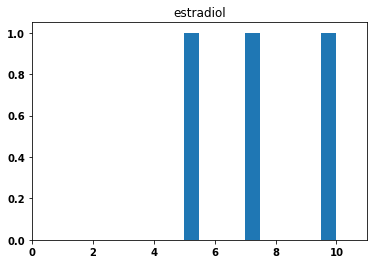

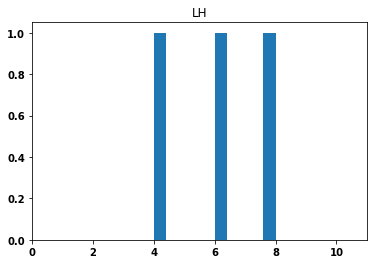

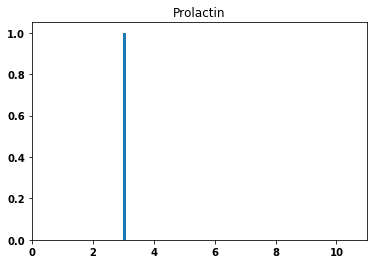

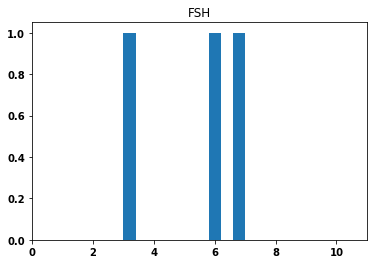

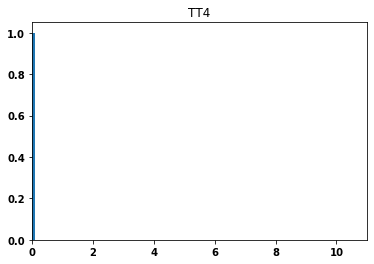

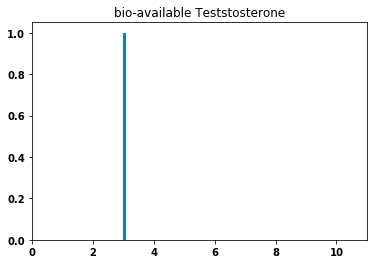

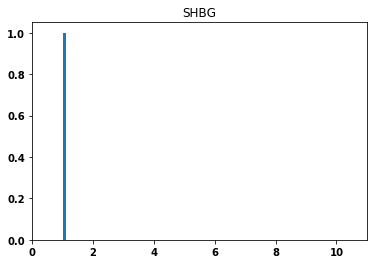

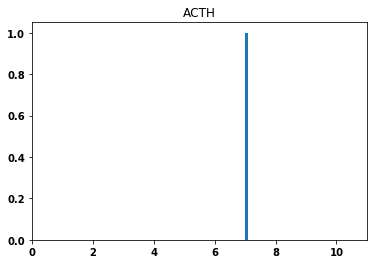

In [45]:
df = pd.read_excel('../HP seasonality review.xlsx')
df = df[['SEX','Hormone','latitude','Acrophase']].copy()
df = df.loc[df['Hormone'] != '-']
df = df.loc[df['Acrophase'] != 'winter and summer peak']
df = df.loc[df['Hormone'] != 'TRH test']

seas = {'Spring':'April',
        'Summer':'July',
        'Fall'  :'October',
        'Winter':'January'}

for sea in seas:
    df.loc[df['Acrophase'] == sea,['Acrophase']] = seas[sea]

df['Acrophase'] = [month[:3] for month in df['Acrophase']]   

month_place = {'Dec':0,
               'Jan':1,
               'Feb':2,
               'Mar':3,
               'Apr':4,               
               'May':5,
               'Jun':6,
               'Jul':7,
               'Aug':8,
               'Sep':9,
               'Oct':10,
               'Nov':11}

df['Acrophase_i'] = [month_place[month] for month in df['Acrophase']]   

df.loc[df['latitude']<0,['Acrophase_i']] = df.loc[df['latitude']<0,['Acrophase_i']] - 6

for hormone in list(set(df['Hormone'])):
    hdf = df.loc[df['Hormone']==hormone].copy()
    plt.hist(hdf['Acrophase_i'])
    plt.title(hormone)
    plt.xlim([0,11])
    plt.show()
    
## add results of clalit acrophase


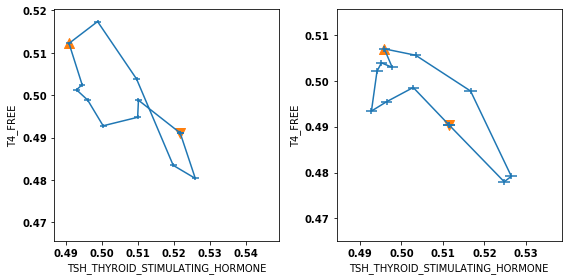

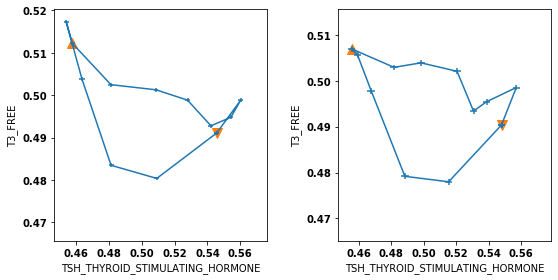

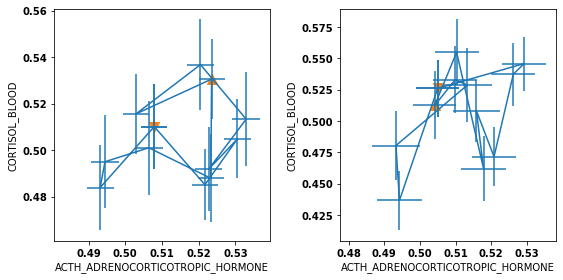

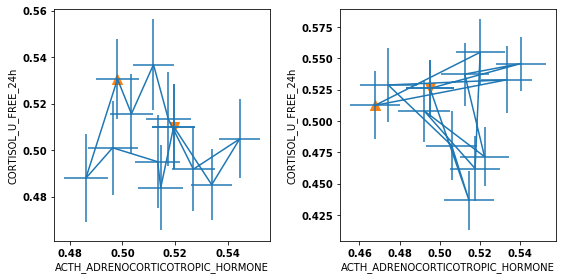

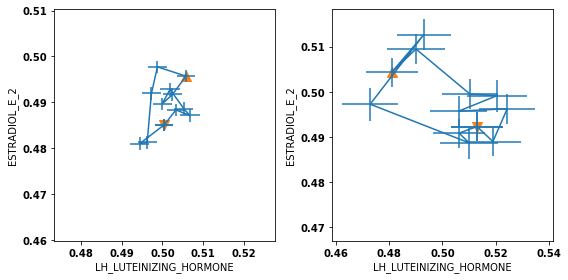

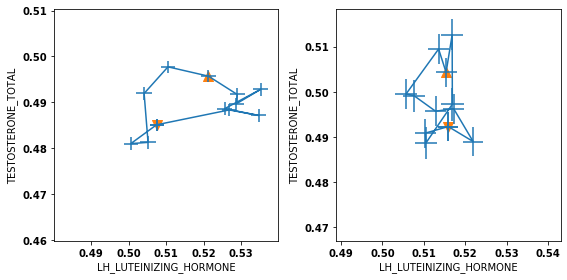

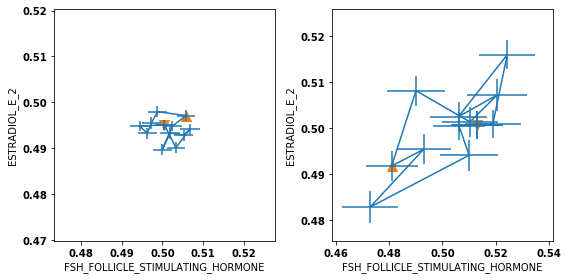

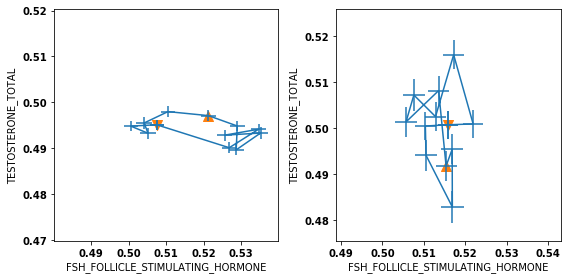

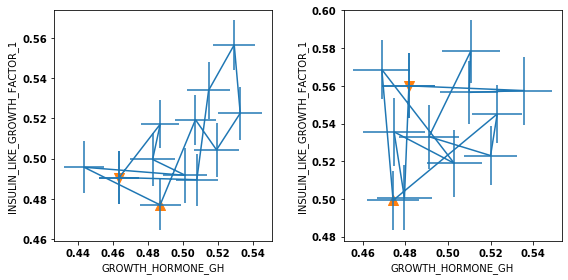

In [166]:
pairs = [['TSH_THYROID_STIMULATING_HORMONE' ,'T4_FREE'],
         ['TSH_THYROID_STIMULATING_HORMONE' ,'T3_FREE'],
         ['ACTH_ADRENOCORTICOTROPIC_HORMONE','CORTISOL_BLOOD'],
         ['ACTH_ADRENOCORTICOTROPIC_HORMONE','CORTISOL_U_FREE_24h'],
         ['LH_LUTEINIZING_HORMONE'          ,'ESTRADIOL_E_2'],
         ['LH_LUTEINIZING_HORMONE'          ,'TESTOSTERONE_TOTAL'],
         ['FSH_FOLLICLE_STIMULATING_HORMONE','ESTRADIOL_E_2'],
         ['FSH_FOLLICLE_STIMULATING_HORMONE','TESTOSTERONE_TOTAL'],
         ['GROWTH_HORMONE_GH'               ,'INSULIN_LIKE_GROWTH_FACTOR_1']]


for pair in pairs:
    plt.figure(figsize=(8,4))
    for i,sex in enumerate(['female','male']):
        ax = plt.subplot(1,2,i+1)
        k   = pair[0]
        j   = pair[1]

        yloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['yloc']
        yloc    = np.insert(yloc, 12, yloc[0])
        yerr    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['err'].values

        yerr    = np.insert(yerr, 12, yerr[0])

        xloc    = effector_list[effector_hormone_dic[j]][sex]['Clalit']['yloc']
        xloc    = np.insert(xloc, 12, xloc[0])
        xerr    = effector_list[effector_hormone_dic[j]][sex]['Clalit']['err'].values
        xerr    = np.insert(xerr, 12, xerr[0])

        ax.scatter(xloc[0],yloc[0],c=def_color[1],s=100,marker='v',zorder=1)
        ax.scatter(xloc[7],yloc[7],c=def_color[1],s=100,marker='^',zorder=1)
        ax.errorbar(xloc,yloc,yerr=yerr,xerr=xerr)

        ax.set_xlabel(k)
        ax.set_ylabel(j)

    plt.tight_layout()
    plt.show()

In [ ]:
pairs = [['TSH_THYROID_STIMULATING_HORMONE' ,'T4_FREE'],
         ['TSH_THYROID_STIMULATING_HORMONE' ,'T3_FREE'],
         ['ACTH_ADRENOCORTICOTROPIC_HORMONE','CORTISOL_BLOOD'],
         ['ACTH_ADRENOCORTICOTROPIC_HORMONE','CORTISOL_U_FREE_24h'],
         ['LH_LUTEINIZING_HORMONE'          ,'ESTRADIOL_E_2'],
         ['LH_LUTEINIZING_HORMONE'          ,'TESTOSTERONE_TOTAL'],
         ['FSH_FOLLICLE_STIMULATING_HORMONE','ESTRADIOL_E_2'],
         ['FSH_FOLLICLE_STIMULATING_HORMONE','TESTOSTERONE_TOTAL'],
         ['GROWTH_HORMONE_GH'               ,'INSULIN_LIKE_GROWTH_FACTOR_1']]


for pair in pairs:
    plt.figure(figsize=(8,4))
    for i,sex in enumerate(['female','male']):
        ax = plt.subplot(1,2,i+1)
        k   = pair[0]
        j   = pair[1]

        yloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['yloc']
        yloc    = np.insert(yloc, 12, yloc[0])
        yerr    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['err'].values

        yerr    = np.insert(yerr, 12, yerr[0])

        xloc    = effector_list[effector_hormone_dic[j]][sex]['Clalit']['yloc']
        xloc    = np.insert(xloc, 12, xloc[0])
        xerr    = effector_list[effector_hormone_dic[j]][sex]['Clalit']['err'].values
        xerr    = np.insert(xerr, 12, xerr[0])

        ax.scatter(xloc[0],yloc[0],c=def_color[1],s=100,marker='v',zorder=1)
        ax.scatter(xloc[7],yloc[7],c=def_color[1],s=100,marker='^',zorder=1)
        ax.errorbar(xloc,yloc,yerr=yerr,xerr=xerr)

        ax.set_xlabel(k)
        ax.set_ylabel(j)

    plt.tight_layout()
    plt.show()

7

In [ ]:
# for j,hormone in enumerate(eff_big):
#     name = hormone[0]
#     sex  = hormone[1]
# #     if name == 'T4_FREE':
# #         continue  
#     acrophase = effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][2]
#     relmaxmin = effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][3]
#     p     = (acrophase/12)*2*np.pi
#     cosine= 1+relmaxmin*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
#     cosine= np.insert(cosine, 365, cosine[0])
#     stack_eff_cos.append(cosine)
    
# for j,hormone in enumerate(pit_big):
#     name = hormone[0]
#     if name == 'GROWTH_HORMONE_GH':
#         continue    
#     sex  = hormone[1]
#     if name == 'FSH_FOLLICLE_STIMULATING_HORMONE':
#         if sex =='male':
#             continue
#     acrophase = pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][2]
#     relmaxmin = pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][3]
#     p     = (acrophase/12)*2*np.pi
#     cosine= 1+relmaxmin*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
#     cosine= np.insert(cosine, 365, cosine[0])
#     stack_pit_cos.append([cosine])

# pit_cos = np.mean(stack_pit_cos,axis=0).flat
# eff_cos = np.mean(stack_eff_cos,axis=0)

In [ ]:
 # def boots_max_phase(dat,nboots=100):
#     vals=np.zeros(nboots)
#     mean_dat=np.array(dat['mean'])
#     for i in range(nboots):
#         inds=np.random.randint(0,12,12)
#         vals[i]=np.where(mean_dat==np.max(mean_dat[inds]))[0][0]
#     return np.mod(circmean(vals+0.5,high=12.5, low=0.5),12),np.mod(circstd(vals+0.5,high=12.5, low=0.5),12)

# def get_relative_amp(boots_mat):
#     '''
#     ALON - ADD DIVISION BY 2
#     Input is bootstrp result (output of bootstrap_months_cosinor method)
#     Output is the mean and std of the maxmin/mesor
#     '''
#     v=(boots_mat[:,3]/boots_mat[:,0])/2
#     return np.mean(v),np.std(v)

# def get_maxmin(boots_mat):
#     '''
#     Input is bootstrp result (output of bootstrap_months_cosinor method)
#     Output is the mean and std of the max-min of booststrap
#     '''
#     v=boots_mat[:,3]
#     return np.mean(v),np.std(v)

# def get_actophase(boots_mat):
#     '''
#     Input is bootstrp result (output of bootstrap_months_cosinor method)
#     Output is the mean and std of the max-min of booststrap
#     '''
#     v=boots_mat[:,6]
#     return np.mean(v),np.std(v)

# def get_mesor(boots_mat):
#     '''
#     Input is bootstrp result (output of bootstrap_months_cosinor method)
#     Output is the mean and std of the mesor
#     '''
#     v=boots_mat[:,0]
#     return np.mean(v),np.std(v)


# def get_phase_pval(boots_mat):
#     '''
#     Input is bootstrp result (output of bootstrap_months_cosinor method)
#     Output is the p-value of deviation of the phase from 21.12
#     '''
#     v=boots_mat[:,2]
#     mean_phase_neg=np.mod((-circmean(v,high=np.pi, low=-np.pi)+np.pi)*12/(2*np.pi)+10/365*12,12)  
#     month_phases=[np.mod(12/(2*np.pi)*(-x+2*np.pi*10/365),12) for x in v]
#     v1=sum(month_phases>mean_phase_neg)
#     v2=len(month_phases)-v1
#     return min(v1,v2)/(v1+v2)

# def get_phase2_pval(boots_mat):
#     '''
#     Input is bootstrp result (output of bootstrap_months_cosinor method)
#     Output is the p-value of deviation of the phase from 21.12
#     '''
#     v=boots_mat[:,5]
#     mean_phase_neg=np.mod((-circmean(v,high=np.pi, low=-np.pi)+np.pi)*12/(2*np.pi)+10/365*12,12)  
#     month_phases=[np.mod(12/(2*np.pi)*(-x+2*np.pi*10/365),12) for x in v]
#     v1=sum(month_phases>mean_phase_neg)
#     v2=len(month_phases)-v1
#     return min(v1,v2)/(v1+v2)